In [1]:
import os
import glob
import itertools
import json
import importlib
import cv2

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import tifffile as tf


In [2]:
cd ..

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations


In [3]:
from utils import plotting as pplot
from utils import rf_utils as rfutils
from utils import gratings_utils as gutils
from utils import roi_utils as roiutils
from utils import retino_utils as retutils
from utils import aggregate_datasets as aggr
from utils import helpers as hutils

In [4]:
%matplotlib notebook

In [5]:
import allensdk as ak

# Source

In [15]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'

traceid = 'traces001'
response_type='dff'
responsive_test='nstds'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=1000
n_resamples=20

print(responsive_test, responsive_thr)

nstds 10.0


# Plotting

In [16]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

# Aggregate meta 

In [17]:
importlib.reload(aggr)

<module 'utils.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/aggregate_datasets.py'>

In [18]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# cells, missing_seg = aggr.get_cells_by_area(sdata, return_missing=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()

all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets


animalid  session  fovnum
visual_area                           
Li                 15       15      15
Lm                 11       11      11
V1                  9        9       9

In [19]:
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters, 
                            n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


# Output dir

In [20]:
dst_dir = os.path.join(aggregate_dir, 'gratings-tuning', 
                       '%s-%s' % (traceid, ori_fit_desc))
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


# All fits

In [21]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, fit_desc=ori_fit_desc,
                             return_missing=True) 
gdata = hutils.split_datakey(gdata)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/gratings_utils.py:174: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


In [22]:
gdata['tf'] = gdata['sf']*gdata['speed'] # fit params
gdata.head()

asi       dsi  response_null  response_offset  response_pref  \
0  0.528705  0.524802       0.025275        -0.010931       0.038352   
1  0.341041  0.685649       0.020652        -0.017558       0.059309   
2  0.590751  0.679958       0.009313        -0.001160       0.027233   
3  0.241354  0.572965       0.024139        -0.021777       0.047835   
4  0.407956  0.362389       0.017694        -0.012919       0.037090   

       sigma  theta_pref        r2   cell    r2comb       gof   sf  size  \
0  52.129545    0.000000  0.727584  160.0  0.365496  0.376922  0.1  60.0   
1  53.811532  132.244898  0.793545  170.0  0.323455  0.397306  0.1  60.0   
2  39.562740  352.653061  0.892822  172.0  0.899031  0.765403  0.1  60.0   
3  69.826945  227.755102  0.671892  177.0  0.660583  0.458513  0.1  60.0   
4  70.338493   80.816327  0.603767  178.0  0.327887  0.230345  0.1  60.0   

   speed visual_area              datakey animalid            fov   session  \
0   10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314   
1   10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314   
2   10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314   
3   10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314   
4   10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314   

    tf  
0  1.0  
1  1.0  
2  1.0  
3  1.0  
4  1.0

In [23]:
gdata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

datakey
visual_area         
Li                15
Lm                10
V1                 9

In [24]:
gdata[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

datakey  cell
visual_area               
Li               261   261
Lm               619   619
V1               686   686

In [25]:
missing_

['Lm_20191111_JC120_fov1']

# All data

In [26]:
importlib.reload(aggr)

<module 'utils.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/aggregate_datasets.py'>

In [27]:
trial_epoch='plushalf'
experiment='gratings'
NDATA = aggr.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, verbose=False,
                      responsive_thr=responsive_thr, n_stds=n_stds)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl
20190314_JC070_fov1
[Li] 20190314_JC070_fov1: 137 cells responsive (116 in fov)
Neuraldf: (80, 38)
20190315_JC070_fov2
[Li] 20190315_JC070_fov2: 102 cells responsive (45 in fov)
Neuraldf: (80, 8)
20190319_JC067_fov1
[Li] 20190319_JC067_fov1: 46 cells responsive (141 in fov)
Neuraldf: (80, 10)
20190522_JC089_fov1
[Li] 20190522_JC089_fov1: 32 cells responsive (16 in fov)
Neuraldf: (623, 9)
20190527_JC092_fov3
[Li] 20190527_JC092_fov3: 118 cells responsive (8 in fov)
Neuraldf: (320, 8)
20190602_JC091_fov1
[Li] 20190602_JC091_fov1: 197 cells responsive (85 in fov)
Neuraldf: (1280, 66)
20190606_JC091_fov1
[Li] 20190606_JC091_fov1: 175 cells responsive (30 in fov)
Neuraldf: (1280, 23)
20190607_JC091_fov1
[Li] 20190607_JC091_fov1: 280 cells resp

In [10]:
# experiment='gratings'
# data_outfile = aggr.get_aggregate_data_filepath(experiment, traceid=traceid,
#                         response_type=response_type, epoch='plushalf',
#                         responsive_test=responsive_test,
#                         responsive_thr=responsive_thr, n_stds=n_stds,
#                         aggregate_dir=aggregate_dir)
# print(data_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


In [11]:
# import _pickle as pkl

In [12]:
# with open(data_outfile, 'rb') as f:
#     MEANS = pkl.load(f, encoding='latin1')
#MEANS = pd.read_pickle(data_outfile) #, encoding='latin1')

#### Filter fits

In [28]:
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
        .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
        .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()
bestg.groupby(['visual_area']).count()

asi  dsi  response_null  response_offset  response_pref  sigma  \
visual_area                                                                   
Li           261  261            261              261            261    261   
Lm           619  619            619              619            619    619   
V1           686  686            686              686            686    686   

             theta_pref   r2  cell  r2comb  gof   sf  size  speed  datakey  \
visual_area                                                                  
Li                  261  261   261     261  261  261   261    261      261   
Lm                  619  619   619     619  619  619   619    619      619   
V1                  686  686   686     686  686  686   686    686      686   

             animalid  fov  session   tf  
visual_area                               
Li                261  261      261  261  
Lm                619  619      619  619  
V1                686  686      686  686

In [29]:
# old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
# bestg = p3.split_datakey(bestg)
# bestg = bestg[~bestg.animalid.isin(old_rats)]
# bestg[bestg.visual_area=='Li']['datakey']

In [30]:
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = list(tested_thetas.copy())
theta_vals.append(360)
theta_vals = np.array(theta_vals)
bestg['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)== np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in bestg['theta_pref']]
bestg['tested_theta'] = bestg['tested_theta'].astype(float)

# Aggregate metrics

In [33]:
%matplotlib notebook

In [31]:
#### Set current output dir
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics


visual_area
Li     98
Lm    293
V1    341
Name: cell, dtype: int64


<IPython.core.display.Javascript object>


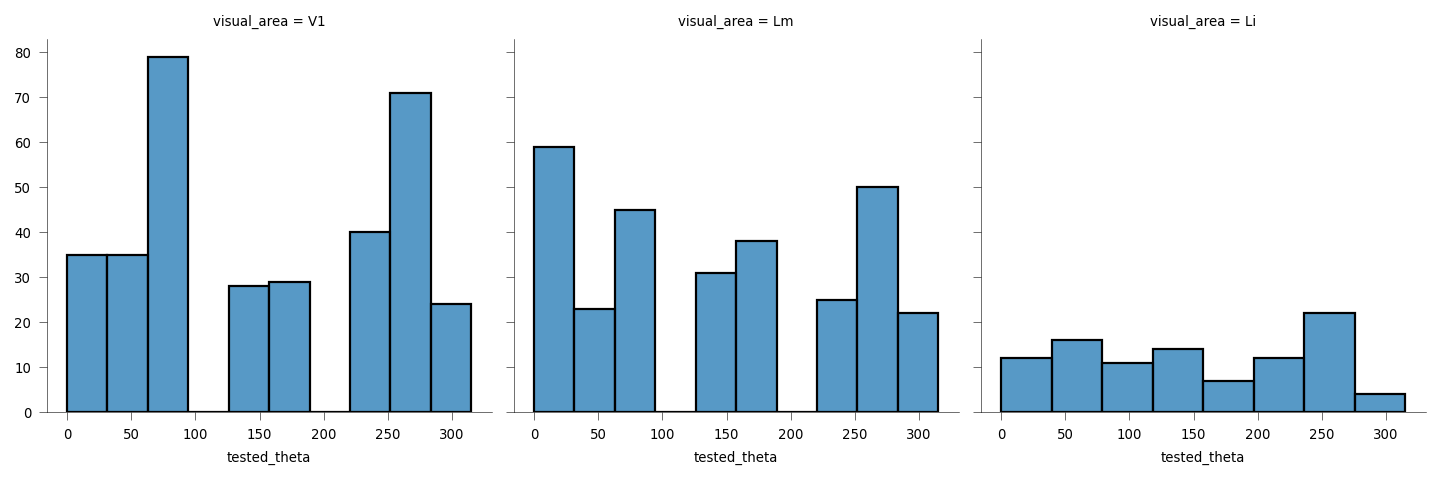

In [34]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()
print(passg.groupby(['visual_area'])['cell'].count())
fg = sns.FacetGrid(passg, col='visual_area', col_order=visual_areas, height=3)
fg.map(sns.histplot, 'tested_theta')

In [55]:
gdata.head()

asi       dsi  response_null  response_offset  response_pref  \
0  0.528705  0.524802       0.025275        -0.010931       0.038352   
1  0.341041  0.685649       0.020652        -0.017558       0.059309   
2  0.590751  0.679958       0.009313        -0.001160       0.027233   
3  0.241354  0.572965       0.024139        -0.021777       0.047835   
4  0.407956  0.362389       0.017694        -0.012919       0.037090   

       sigma  theta_pref        r2   cell    r2comb       gof   sf  size  \
0  52.129545    0.000000  0.727584  160.0  0.365496  0.376922  0.1  60.0   
1  53.811532  132.244898  0.793545  170.0  0.323455  0.397306  0.1  60.0   
2  39.562740  352.653061  0.892822  172.0  0.899031  0.765403  0.1  60.0   
3  69.826945  227.755102  0.671892  177.0  0.660583  0.458513  0.1  60.0   
4  70.338493   80.816327  0.603767  178.0  0.327887  0.230345  0.1  60.0   

   speed visual_area              datakey animalid            fov   session  
0   10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314  
1   10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314  
2   10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314  
3   10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314  
4   10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314

## Example polar

#### Test 1 animal

In [35]:
va='V1'
#dk='20190522_JC084_fov1'
dk = '20190617_JC097_fov1'
ori_dir = gutils.get_ori_dir(dk, traceid=traceid, fit_desc=ori_fit_desc)
print(ori_dir)

/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_e3c1f2_traces001_467d9f_traces001_88209d_traces001_359554/tuning/fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [36]:
# from class Gratings.get_tuning()
# Gets ori_fit_desc
# Loads tuning results (bootstrapped)
fitresults, fitparams = gutils.load_tuning_results(dk, 
                                fit_desc=ori_fit_desc, traceid=traceid)
g = CELLS[(CELLS.visual_area==va) & (CELLS.datakey==dk)]
# Get OSI results
rois_ = g['cell'].unique()
boot_ = dict((k, v) for k, v in fitresults.items() if k in rois_)
    
# Get fits
best_fits, all_fits = gutils.get_good_fits(boot_, fitparams, 
                                                 gof_thr=None, verbose=False)
# if rmetrics is None:
#     no_fits.append('%s_%s' % (va, dk))
#     continue

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/gratings_utils.py:174: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


In [39]:
rid=155
fitresults[rid].keys()
cfg_values = [tuple(c) for c in fitparams['non_ori_configs']]


In [40]:
n_intervals_interp = 3
stimparam = cfg_values[0]
bootr = boot_[rid][stimparam]
thetas_interp = bootr['fits']['xv']
thetas = bootr['fits']['xv'][0::n_intervals_interp]

In [41]:
r2comb, gof, fitr = gutils.evaluate_fits(bootr, interp=True)
origr0 = bootr['data']['responses'].mean(axis=0).values
#origr = np.abs(origr0 - origr0.mean())
origr = (origr0 - origr0.min()) #- (origr0 - origr0.mean()).min()
origr = np.append(origr, origr[0]) # wrap back around
print(len(origr), len(fitr)) 

9 25


In [42]:
gof_thr=0.5
pass_gof = gdata[gdata['gof']>=gof_thr].copy()
best_ixs = pass_gof\
                .groupby(['visual_area', 'datakey', 'cell'])['response_pref']\
                .transform(max) == pass_gof['response_pref']
best_fits = pass_gof.loc[best_ixs].copy()
best_fits.head()

asi       dsi  response_null  response_offset  response_pref  \
2   0.590751  0.679958       0.009313        -0.001160       0.027233   
5   0.357954  0.742214       0.003853        -0.000182       0.033124   
6   0.060657  0.418246       0.000417        -0.025977       0.101769   
9   0.669880  0.416914       0.016238        -0.000277       0.029183   
11  0.392090  0.723005       0.008937        -0.003883       0.030799   

        sigma  theta_pref        r2   cell    r2comb       gof   sf  size  \
2   39.562740  352.653061  0.892822  172.0  0.899031  0.765403  0.1  60.0   
5   44.937365  257.142857  0.926326  187.0  0.922391  0.835984  0.1  60.0   
6   99.134356   95.510204  0.888896  190.0  0.904245  0.812975  0.1  60.0   
9   32.349965    0.000000  0.881019  216.0  0.644633  0.650666  0.1  60.0   
11  52.672152    0.000000  0.888877  220.0  0.819293  0.758257  0.1  60.0   

    speed visual_area              datakey animalid            fov   session  \
2    10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314   
5    10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314   
6    10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314   
9    10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314   
11   10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314   

     tf  
2   1.0  
5   1.0  
6   1.0  
9   1.0  
11  1.0

In [45]:
importlib.reload(gutils)

<module 'utils.gratings_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/gratings_utils.py'>

In [188]:
def get_peak(currdata):
    dg_params=['ori', 'size', 'sf', 'tf', 'speed']
    #rid = int(currdata['cell'].unique())
    meanr = currdata.groupby(dg_params).mean()['response'].reset_index()
    # meanr.groupby(['sf']).mean()['response'].idxmax()

    peak={}
    for p in dg_params:
        #pref_ = meanr.groupby([p]).max()['response'].idxmax()
        pref_ = meanr.groupby([p]).mean()['response'].idxmax()
        peak[p] = pref_
    peakdf = pd.Series(peak) #, index=[rid])
    return peakdf

In [186]:
dg_params=['ori', 'speed', 'sf', 'size']

# cfits = best_fits[(best_fits.visual_area==va) & (best_fits.datakey==dk)].copy()
p_=[]
for (va, dk), cfits in best_fits.groupby(['visual_area', 'datakey']):
    currdata = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
    pass_cells = cfits['cell'].unique()
    sdf = aggr.get_stimuli(dk, 'gratings')
    for p in dg_params:
        currdata[p] = sdf.loc[currdata['config']][p].values
    currdata['tf'] = currdata['sf'] * currdata['speed'] # trial data
    pks = currdata[currdata['cell'].isin(pass_cells)].groupby(['cell'])\
            .apply(get_peak).reset_index()
    pks['visual_area'] = va
    pks['datakey'] = dk
    pks['n_total'] = len(currdata['cell'].unique())
    p_.append(pks)

In [216]:
peaks = pd.concat(p_, axis=0)
peaks.head()

cell    ori  size   sf   tf  speed visual_area              datakey  \
0   172    0.0  60.0  0.1  1.0   10.0          Li  20190314_JC070_fov1   
1   187  270.0  60.0  0.1  1.0   10.0          Li  20190314_JC070_fov1   
2   190   90.0  60.0  0.1  1.0   10.0          Li  20190314_JC070_fov1   
3   216    0.0  60.0  0.1  1.0   10.0          Li  20190314_JC070_fov1   
4   220    0.0  60.0  0.1  1.0   10.0          Li  20190314_JC070_fov1   

   n_total  
0       37  
1       37  
2       37  
3       37  
4       37

In [219]:
nfits = peaks[peaks['n_total']>=min_ncells]\
        .groupby(['visual_area', 'datakey'])['cell'].count().reset_index()\
        .rename(columns={'cell': 'n_fit'})
nfits.head()

visual_area              datakey  n_fit
0          Li  20190314_JC070_fov1     16
1          Li  20190602_JC091_fov1     20
2          Li  20190606_JC091_fov1      6
3          Li  20190607_JC091_fov1     12
4          Li  20190612_JC099_fov1      5

In [232]:
min_ncells=10
meanprefs = peaks[peaks['n_total']>=min_ncells].groupby(['visual_area', 'datakey']).mean().reset_index()

df = pd.merge(meanprefs,nfits)
df['fraction_fit'] = df['n_fit'] / df['n_total'] #[
df

visual_area              datakey        cell         ori        size  \
0           Li  20190314_JC070_fov1  249.562500  106.875000   60.000000   
1           Li  20190602_JC091_fov1   95.500000  189.000000   38.500000   
2           Li  20190606_JC091_fov1  183.833333  105.000000   86.666667   
3           Li  20190607_JC091_fov1  161.750000  187.500000   30.000000   
4           Li  20190612_JC099_fov1  149.200000  234.000000   98.000000   
5           Li  20190614_JC091_fov1  205.416667  202.500000   44.166667   
6           Li  20190617_JC099_fov1   40.333333   75.000000  143.333333   
7           Li  20191018_JC113_fov1  101.333333  150.000000   30.000000   
8           Lm  20190306_JC061_fov2   90.709677   85.645161   60.000000   
9           Lm  20190314_JC070_fov2  178.692308   65.769231   60.000000   
10          Lm  20190512_JC083_fov1  121.300000  117.000000   85.000000   
11          Lm  20190513_JC078_fov1  148.297521  160.661157  103.057851   
12          Lm  20190517_JC083_fov1   74.200000   81.000000   64.000000   
13          Lm  20190525_JC084_fov1  123.060606  188.181818   96.969697   
14          Lm  20190603_JC080_fov1  124.136364  176.931818   84.090909   
15          Lm  20190618_JC097_fov1   86.285714  173.571429   90.714286   
16          Lm  20190627_JC091_fov1  194.100000  180.000000  132.000000   
17          V1  20190511_JC083_fov1   95.649351  124.480519   47.272727   
18          V1  20190512_JC083_fov1  290.333333  135.000000  106.666667   
19          V1  20190522_JC084_fov1  129.315068  164.589041   49.589041   
20          V1  20190613_JC097_fov1   79.941176  182.647059   51.764706   
21          V1  20190616_JC097_fov1  200.295455  195.340909   20.000000   
22          V1  20190617_JC097_fov1  170.470588  215.735294   57.058824   
23          V1  20190622_JC085_fov1  182.074074  126.666667   23.333333   
24          V1  20191006_JC110_fov1  143.809524  113.571429   37.142857   

          sf        tf      speed  n_total  n_fit  fraction_fit  
0   0.100000  1.000000  10.000000     37.0     16      0.432432  
1   0.160000  1.700000  12.500000     65.0     20      0.307692  
2   0.233333  3.333333  10.000000     22.0      6      0.272727  
3   0.266667  3.333333  12.500000     43.0     12      0.279070  
4   0.180000  2.800000  10.000000     19.0      5      0.263158  
5   0.166667  2.166667  13.333333     45.0     12      0.266667  
6   0.233333  3.000000  10.000000     10.0      3      0.300000  
7   0.233333  2.500000  11.666667     32.0      6      0.187500  
8   0.100000  1.000000  10.000000     77.0     31      0.402597  
9   0.100000  1.000000  10.000000     70.0     13      0.185714  
10  0.260000  5.200000  20.000000    155.0     10      0.064516  
11  0.238843  3.190083  12.975207    188.0    121      0.643617  
12  0.420000  6.200000  14.000000     11.0      5      0.454545  
13  0.172727  2.242424  13.636364     64.0     33      0.515625  
14  0.209091  2.477273  12.727273     93.0     44      0.473118  
15  0.214286  3.000000  11.428571     32.0     14      0.437500  
16  0.340000  4.350000  12.000000     41.0     20      0.487805  
17  0.219481  4.389610  20.000000    138.0     77      0.557971  
18  0.100000  2.000000  20.000000     36.0      3      0.083333  
19  0.165753  2.438356  14.931507    115.0     73      0.634783  
20  0.194118  2.647059  12.352941     67.0     34      0.507463  
21  0.209091  2.500000  11.363636    182.0     44      0.241758  
22  0.252941  2.764706  12.647059     86.0     34      0.395349  
23  0.137037  1.296296  10.000000    106.0     54      0.509434  
24  0.176190  2.285714  11.904762     93.0     21      0.225806

<IPython.core.display.Javascript object>


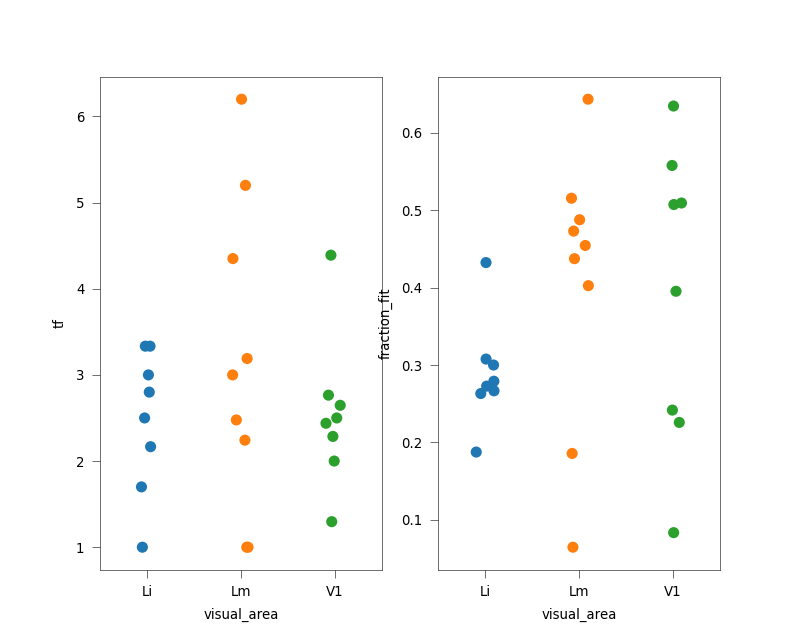

<AxesSubplot:xlabel='visual_area', ylabel='fraction_fit'>

In [233]:

fig, axn = pl.subplots(1,2)
# sns.histplot(x='tf', hue='visual_area', data=peaks, ax=ax,
#               multiple='dodge', palette=area_colors, bins=18,
#               hue_order=area_colors)
ax=axn[0]
sns.stripplot(x='visual_area', y='tf', data=df, ax=ax)

ax=axn[1]
sns.stripplot(x='visual_area', y='fraction_fit', data=df, ax=ax)
#               multiple='dodge', palette=area_colors, bins=18,
#               hue_order=area_colors)

In [60]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def exp_function(x, a, b, c):
    return a*np.exp(-b*x)+c
from scipy.optimize import curve_fit

In [373]:
def fit_tf_tuning(tf_response, pref_tf, return_curve=False):
    '''
    Adapt ALLENSDK:
    https://github.com/AllenInstitute/AllenSDK/blob/master/allensdk/brain_observatory/ecephys/stimulus_analysis/drifting_gratings.py
    
    '''
    tf_tuning = tf_response.values
    tf_values = tf_response.index.tolist()
    n_values = len(tf_values)

    tf_prediction=None; tf_predictions=None; tf_=None;
    
    fit_tf_ind = np.NaN
    fit_tf = np.NaN
    tf_low_cutoff = np.NaN
    tf_high_cutoff = np.NaN

    pref_tf_ix = tf_values.index(pref_tf)
    if pref_tf_ix in [1, 2]:
        try:
            assert n_values == 4, "Wrong N tfs: %s" % str(tf_values)
            xvs = np.arange(tf_values[0], tf_values[3]+.1, 0.1)
            popt, pcov = curve_fit(gauss_function, tf_values, tf_tuning, 
                                   p0=[np.amax(tf_tuning), pref_tf_ix, 1.],
                                   maxfev=2000)
            tf_prediction = gauss_function(xvs, *popt)
            fit_tf_ind = popt[1]
            fit_tf = popt[1] #np.power(2, popt[1])
            low_cut_ind = np.abs(tf_prediction - (tf_prediction.max() / 2.))[:tf_prediction.argmax()].argmin()
            high_cut_ind = np.abs(tf_prediction - (tf_prediction.max() / 2.))[
                           tf_prediction.argmax():].argmin() + tf_prediction.argmax()
            if low_cut_ind > 0:
                low_cutoff = xvs[low_cut_ind]
                tf_low_cutoff = np.power(2, low_cutoff)
            elif high_cut_ind < 49:
                high_cutoff = xvs[high_cut_ind]
                tf_high_cutoff = np.power(2, high_cutoff)
        except Exception as e:
            #print(e)
            pass
    else:
        fit_tf_ind = pref_tf_ix
        fit_tf = pref_tf
        try:
            assert n_values == 4, "Wrong N tfs: %s" % str(tf_values)
            xvs = np.arange(tf_values[0], tf_values[3]+.1, 0.1)
            popt, pcov = curve_fit(exp_function, tf_values, tf_tuning,
                                   p0=[np.amax(tf_tuning), 2., np.amin(tf_tuning)], maxfev=2000)
            tf_prediction = exp_function(xvs, *popt)
            #print(tf_prediction)
            if pref_tf_ix == 0:
                high_cut_ind = np.abs(tf_prediction - (tf_prediction.max() / 2.))[
                               tf_prediction.argmax():].argmin() + tf_prediction.argmax()
                high_cutoff = xvs[high_cut_ind]
                tf_high_cutoff = xvs[high_cut_ind] #np.power(2, high_cutoff)
            else:
                low_cut_ind = np.abs(tf_prediction - (tf_prediction.max() / 2.))[
                              :tf_prediction.argmax()].argmin()
                low_cutoff = xvs[low_cut_ind]
                tf_low_cutoff = xvs[low_cut_ind] #np.power(2, low_cutoff)
        except Exception as e:
            #print(e)
            pass
    tf_ = pd.Series( (fit_tf_ind, fit_tf, tf_low_cutoff, tf_high_cutoff), 
                index=['tf_index', 'tf_value', 'tf_low_cutoff', 'tf_high_cutoff'])
    
    if return_curve:
        tf_predictions = pd.DataFrame({'tf': xvs, 'response': tf_prediction})
        return tf_predictions, tf_
    else:
        return tf_

In [362]:
def fit_tf_for_cell(d):
    
    peakdf = get_peak(d)
    tf_response = d[d['ori']==peakdf.ori]\
                    .groupby(['tf']).mean()['response']
    tf_ = fit_tf_tuning(tf_response, peakdf.tf, return_curve=False)
    return tf_.tf_value

In [451]:
dg_params=['ori', 'speed', 'sf', 'size']

# cfits = best_fits[(best_fits.visual_area==va) & (best_fits.datakey==dk)].copy()
t_=[]
for (va, dk), cfits in best_fits.groupby(['visual_area', 'datakey']):
    currdata = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
    
    pass_cells = cfits['cell'].unique()
    sdf = aggr.get_stimuli(dk, 'gratings')
    for p in dg_params:
        currdata[p] = sdf.loc[currdata['config']][p].values
    currdata['tf'] = currdata['sf'] * currdata['speed'] # trial data
    tfs = currdata.groupby(['cell']).apply(fit_tf_for_cell).reset_index()\
            .rename(columns={0:'fit_tf'})
    tfs['visual_area'] = va
    tfs['datakey'] = dk
    t_.append(tfs)

tf_df = pd.concat(t_, axis=0).dropna()
print(tf_df.shape, tf_df.dropna().shape)
tf_df.head()

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


(1561, 4) (1561, 4)


cell  fit_tf visual_area              datakey
0   158     1.0          Li  20190314_JC070_fov1
1   160     1.0          Li  20190314_JC070_fov1
2   170     1.0          Li  20190314_JC070_fov1
3   172     1.0          Li  20190314_JC070_fov1
4   177     1.0          Li  20190314_JC070_fov1

In [ ]:
max_tf=10
min_tf =1
plotdf = tf_df[(min_tf < tf_df['fit_tf']) & (tf_df['fit_tf']<max_tf)]
fig, axn = pl.subplots(1,2)
# sns.histplot(x='tf', hue='visual_area', data=peaks, ax=ax,
#               multiple='dodge', palette=area_colors, bins=18,
#               hue_order=area_colors)
ax=axn[0]
sns.stripplot(x='visual_area', y='fit_tf', data=plotdf, ax=ax,
             palette=area_colors, size=2)
sns.pointplot(x='visual_area', y='fit_tf', data=plotdf, ax=ax,
              color='k', scale=1, markers='_', join=False, ci=95)

ax=axn[1]
sns.ecdfplot(x='fit_tf', hue='visual_area', data=plotdf, ax=ax,
             palette=area_colors)

ax=axn[2]
meandf = plotdf.groupby(['visual_area','datakey']).mean().reset_index()
sns.stripplot(x='visual_area', y='fit_tf', data=meandf, ax=ax,
              palette=area_colors, size=2)


# Example 

In [339]:
peaks[(peaks.datakey==dk)]

cell    ori   size   sf    tf  speed visual_area              datakey  \
0      1  135.0   20.0  0.5  10.0   20.0          V1  20190617_JC097_fov1   
1     22  270.0   20.0  0.5   5.0   10.0          V1  20190617_JC097_fov1   
2     37  270.0   20.0  0.5   5.0   10.0          V1  20190617_JC097_fov1   
3     52  270.0   20.0  0.1   2.0   10.0          V1  20190617_JC097_fov1   
4     60  270.0   20.0  0.5   5.0   10.0          V1  20190617_JC097_fov1   
5     65  270.0   20.0  0.5   5.0   20.0          V1  20190617_JC097_fov1   
6     66  270.0   20.0  0.5   5.0   10.0          V1  20190617_JC097_fov1   
7     69  270.0   20.0  0.1   2.0   10.0          V1  20190617_JC097_fov1   
8     91  180.0   20.0  0.5   5.0   10.0          V1  20190617_JC097_fov1   
9    100   45.0   20.0  0.1   2.0   10.0          V1  20190617_JC097_fov1   
10   104  270.0   20.0  0.1   2.0   20.0          V1  20190617_JC097_fov1   
11   107  270.0  200.0  0.5   5.0   20.0          V1  20190617_JC097_fov1   
12   111  270.0  200.0  0.1   1.0   10.0          V1  20190617_JC097_fov1   
13   119  135.0   20.0  0.5   5.0   10.0          V1  20190617_JC097_fov1   
14   123  225.0  200.0  0.1   1.0   10.0          V1  20190617_JC097_fov1   
15   125  270.0   20.0  0.1   1.0   10.0          V1  20190617_JC097_fov1   
16   146   90.0   20.0  0.1   1.0   10.0          V1  20190617_JC097_fov1   
17   155  135.0  200.0  0.1   1.0   10.0          V1  20190617_JC097_fov1   
18   183  225.0   20.0  0.5   1.0   10.0          V1  20190617_JC097_fov1   
19   200  225.0   20.0  0.1   1.0   10.0          V1  20190617_JC097_fov1   
20   203  180.0   20.0  0.1   1.0   10.0          V1  20190617_JC097_fov1   
21   211   90.0   20.0  0.1   2.0   20.0          V1  20190617_JC097_fov1   
22   215  270.0   20.0  0.1   1.0   20.0          V1  20190617_JC097_fov1   
23   216   90.0   20.0  0.1   1.0   10.0          V1  20190617_JC097_fov1   
24   224  270.0   20.0  0.1   1.0   10.0          V1  20190617_JC097_fov1   
25   229   90.0   20.0  0.1   1.0   10.0          V1  20190617_JC097_fov1   
26   262  225.0   20.0  0.5   5.0   10.0          V1  20190617_JC097_fov1   
27   280  270.0   20.0  0.1   2.0   20.0          V1  20190617_JC097_fov1   
28   281  270.0   20.0  0.1   2.0   20.0          V1  20190617_JC097_fov1   
29   291  225.0  200.0  0.5   5.0   20.0          V1  20190617_JC097_fov1   
30   311  270.0  200.0  0.1   1.0   10.0          V1  20190617_JC097_fov1   
31   361  270.0   20.0  0.1   1.0   10.0          V1  20190617_JC097_fov1   
32   377  180.0  200.0  0.5   5.0   10.0          V1  20190617_JC097_fov1   
33   399  270.0   20.0  0.1   1.0   10.0          V1  20190617_JC097_fov1   

    n_total  
0        86  
1        86  
2        86  
3        86  
4        86  
5        86  
6        86  
7        86  
8        86  
9        86  
10       86  
11       86  
12       86  
13       86  
14       86  
15       86  
16       86  
17       86  
18       86  
19       86  
20       86  
21       86  
22       86  
23       86  
24       86  
25       86  
26       86  
27       86  
28       86  
29       86  
30       86  
31       86  
32       86  
33       86

In [356]:
cfits.sort_values(by='gof', ascending=False)

asi       dsi  response_null  response_offset  response_pref  \
2855  0.724190  0.062538       0.190464         0.002313       0.216933   
2909  0.652197  0.043056       0.065501         0.003290       0.070859   
2903  0.531476  0.281152       0.043880        -0.015824       0.060939   
2901  0.735292  0.136445       0.030656         0.005451       0.040743   
2882  0.612574  0.221680       0.055883        -0.003335       0.087221   
2788  0.736206  0.119156       0.041650         0.007465       0.052532   
2868  0.490688  0.383989       0.055296        -0.030111       0.083872   
2840  0.499239  0.125040       0.091523        -0.043420       0.102053   
2828  0.522413  0.207341       0.051003        -0.020495       0.062557   
2841  0.700012  0.177758       0.016232         0.004173       0.022396   
2891  0.515638  0.060433       0.361601        -0.141810       0.374879   
2775  0.195308  0.571425       0.020930        -0.021574       0.090963   
2864  0.568984  0.284794       0.057259        -0.003080       0.090538   
2816  0.370723  0.480029       0.027427        -0.018686       0.049235   
2886  0.517112  0.067108       0.379183        -0.146243       0.391563   
2872  0.547122  0.251392       0.032575        -0.004741       0.046570   
2905  0.557636  0.234414       0.027243        -0.003095       0.037937   
2874  0.543539  0.221551       0.039236        -0.012022       0.049566   
2898  0.211681  0.451133       0.057534        -0.061878       0.146735   
2835  0.561021  0.339591       0.058661        -0.018544       0.091584   
2782  0.496438  0.252988       0.082878        -0.039848       0.102565   
2881  0.535652  0.130167       0.058713        -0.021421       0.065126   
2861  0.542219  0.606168       0.014586        -0.001997       0.037439   
2831  0.544964  0.672891       0.011476        -0.002443       0.038133   
2876  0.612806  0.133287       0.045185        -0.006062       0.053286   
2799  0.552736  0.607409       0.030281        -0.001267       0.081455   
2849  0.620416  0.821566       0.004706         0.011027       0.054012   
2827  0.212774  0.412743       0.022007        -0.024028       0.060719   
2809  0.279860  0.474671       0.022347        -0.021437       0.051133   
2811  0.479725  0.532186       0.018802        -0.006146       0.045352   
2804  0.213157  0.491717       0.019220        -0.023134       0.056257   
2879  0.593357  0.225541       0.032134        -0.003510       0.042696   
2838  0.479337  0.612162       0.015718        -0.000839       0.065348   
2833  0.702417  0.492977       0.020730         0.005491       0.050677   

          sigma  theta_pref        r2   cell    r2comb       gof   sf   size  \
2855  22.500000  132.244898  0.969696  155.0  0.959427  0.941058  0.1  200.0   
2909  27.487368   95.510204  0.945942  399.0  0.947431  0.902898  0.1   20.0   
2903  44.881824   95.510204  0.909346  361.0  0.907863  0.811936  0.5   20.0   
2901  22.551631  264.489796  0.911849  311.0  0.871423  0.796892  0.1  200.0   
2882  32.351343  213.061224  0.891517  262.0  0.868279  0.771322  0.5   20.0   
2788  22.501239  264.489796  0.897492   37.0  0.825375  0.763621  0.1  200.0   
2868  53.812841  176.326531  0.874389  203.0  0.860604  0.732336  0.5   20.0   
2840  52.858012  242.448980  0.853197  123.0  0.834254  0.712952  0.1  200.0   
2828  47.549912  220.408163  0.866126  100.0  0.815328  0.698609  0.1   20.0   
2841  25.717823   88.163265  0.825974  125.0  0.847699  0.663779  0.1  200.0   
2891  50.234671  264.489796  0.833147  281.0  0.799843  0.661122  0.1   20.0   
2775  74.579649  191.020408  0.853096    1.0  0.760906  0.660957  0.1  200.0   
2864  36.881782  235.102041  0.831354  200.0  0.774659  0.646293  0.1  200.0   
2816  63.424353  205.714286  0.816094   69.0  0.850947  0.640098  0.1   20.0   
2886  50.241505  264.489796  0.817455  280.0  0.770157  0.638706  0.1   20.0   
2872  40.212076   80.816327  0.814387  211.0  0.850784  0.628718  0.1   20.0   
2905  37.947727  235.1020

In [363]:
va='V1'
dk='20190617_JC097_fov1'
currdata = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
cfits = best_fits[(best_fits.visual_area==va) & (best_fits.datakey==dk)].copy()

sdf = aggr.get_stimuli(dk, 'gratings')
for p in dg_params:
    currdata[p] = sdf.loc[currdata['config']][p].values
currdata['tf'] = currdata['sf'] * currdata['speed'] # trial data


In [450]:
rid=262 #155 #155 #262
rdata=currdata[currdata['cell']==rid].copy()
meanr = rdata.groupby(['ori', 'tf', 'size']).mean().reset_index()
meanr['ori_rad'] = [np.deg2rad(t) for t in meanr['ori']]

peakdf = get_peak(rdata)
tf_response = rdata[rdata['ori']==peakdf.ori].groupby(['tf']).mean()['response']
tf_prediction, tf_ = fit_tf_tuning(tf_response, peakdf.tf, return_curve=True)
tf_

tf_index          6.033043
tf_value          6.033043
tf_low_cutoff          NaN
tf_high_cutoff         NaN
dtype: float64

[  0.  45.  90. 135. 180. 225. 270. 315.]


<IPython.core.display.Javascript object>


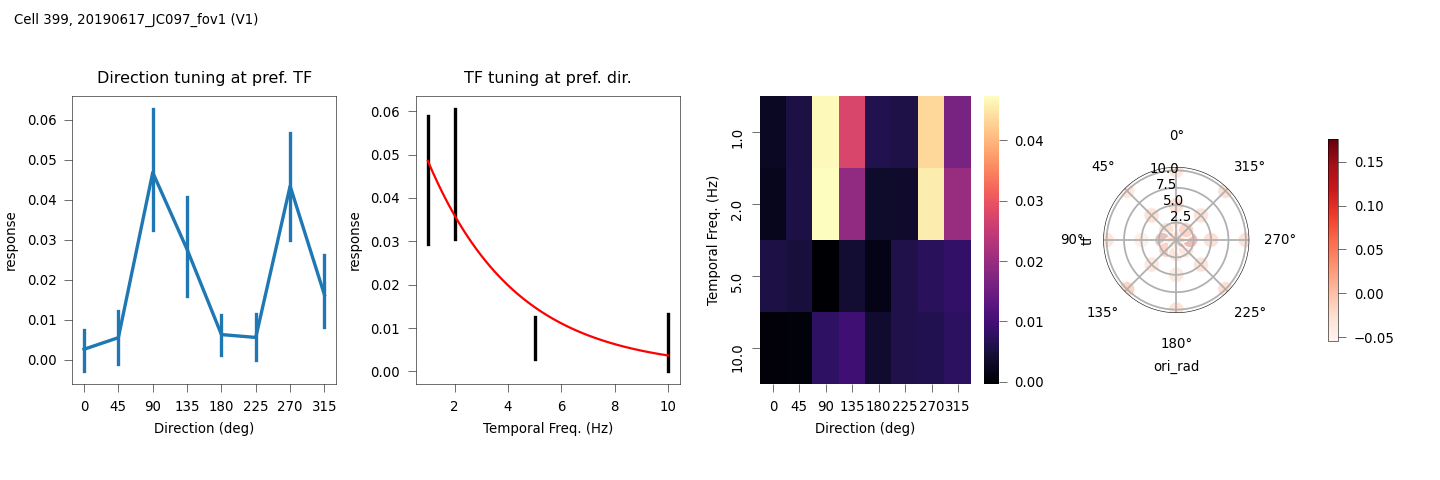

Text(0.01, 0.95, 'Cell 399, 20190617_JC097_fov1 (V1)')

In [448]:
oris=np.linspace(0, 315, 8)
tf_values = sorted(rdata['tf'].unique())
print(oris)
pref_tf = peakdf.tf
pref_dir = peakdf.ori

fig = pl.figure(figsize=(9,3))
#, axn = pl.subplots(1,3, figsize=(8,3))
# Direction tuning # preferred TF
ax=fig.add_subplot(141)
sns.lineplot(x='ori', y='response', data=rdata[rdata['tf']==pref_tf], ax=ax,
            err_style='bars', markers='o')
ax.set_xticks(oris)
ax.set_xlabel('Direction (deg)')
ax.set_title('Direction tuning at pref. TF')

# TF tuning at preferred dir.
ax=fig.add_subplot(142)
# Get fit
tf_response = rdata[rdata['ori']==peakdf.ori].groupby(['tf']).mean()['response']
tf_prediction, tf_ = fit_tf_tuning(tf_response, pref_tf, return_curve=True)
sns.lineplot(x='tf', y='response', data=rdata[rdata['ori']==pref_dir], ax=ax,
            err_style='bars', color='k', lw=0, markers=['o']) #( #=False)
ax.plot(tf_prediction['tf'], tf_prediction['response'], color='r', lw=1)
ax.set_xlabel('Temporal Freq. (Hz)')
ax.set_title('TF tuning at pref. dir.')

# DIR-TF heatmap
ax=fig.add_subplot(143)
dir_tf_map = rdata[['ori', 'tf', 'response']]\
                .pivot_table(index='tf', columns='ori')
sns.heatmap(dir_tf_map.values, ax=ax, cmap='magma')
ax.set_xticklabels([int(i) for i in oris])
ax.set_xlabel('Direction (deg)')
ax.set_yticklabels([i for i in tf_values])
ax.set_ylabel('Temporal Freq. (Hz)')

# Polar scatter
cmap='Reds'
norm = pl.Normalize(rdata['response'].min(), rdata['response'].max())
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ax =fig.add_subplot(144, projection='polar')
sns.scatterplot(x="ori_rad", y="tf", hue="response", data=meanr, s=50,
      alpha=0.8, palette='Reds', ax=ax, legend=False) # vmin=0, vmax=0.1)
ax.set_theta_zero_location('N')
ax.figure.colorbar(sm, shrink=0.7, pad=0.3)

pl.subplots_adjust(left=0.05, right=0.95, wspace=0.3, bottom=0.2, top=0.8)
fig.text(0.01, 0.95, 'Cell %i, %s (%s)' % (rid, dk, va))

In [54]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

<IPython.core.display.Javascript object>


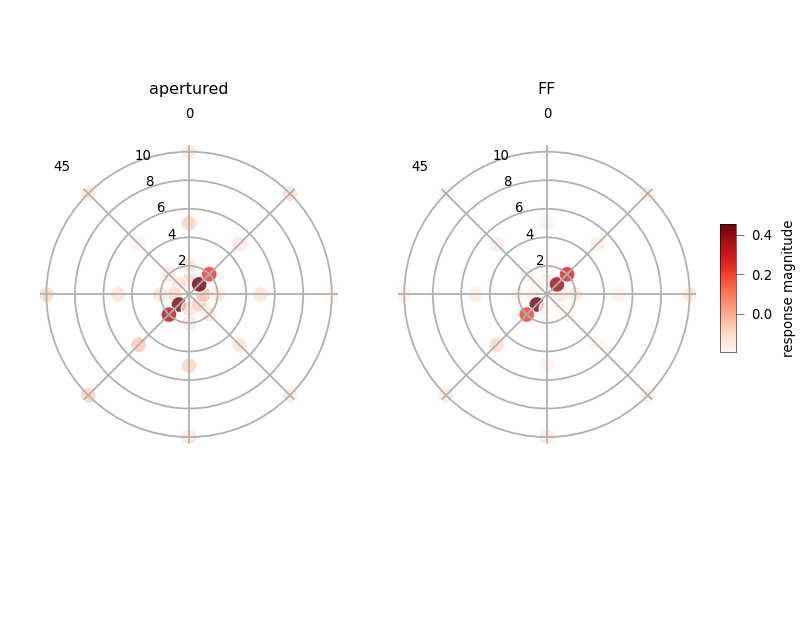

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


In [55]:
fig = pl.figure()

# Polar scatter
cmap='Reds'
vmin=currdata['response'].min()
vmax = currdata['response'].max()
norm = mpl.colors.Normalize(vmin, vmax)
sm = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ax =fig.add_subplot(121, projection='polar')
ax.set_title('apertured')
sns.scatterplot(x="ori_rad", y="tf", hue="response", data=meanr[meanr['size']<200], 
               s=50, alpha=0.8, palette='Reds', ax=ax, legend=False,
               vmin=vmin, vmax=vmax)

ax =fig.add_subplot(122, projection='polar')
ax.set_title('FF')
im=sns.scatterplot(x="ori_rad", y="tf", hue="response", data=meanr[meanr['size']==200], 
              s=50, alpha=0.8, palette='Reds', ax=ax, legend=False,
              vmin=vmin, vmax=vmax)
for ax in fig.axes:
    ax.set_theta_zero_location('N')
    ax.set_xticklabels([0, 45])
    ax.spines['polar'].set_visible(False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
#divider = make_axes_locatable(ax)
cax = fig.add_axes([0.9, 0.45, 0.02, 0.2])
#cbar.ax.set_title("response magnitude")
ax.figure.colorbar(sm, cax=cax, shrink=0.7, pad=0., label='response magnitude')

pl.subplots_adjust(left=0.05, right=0.87, wspace=0.2, bottom=0.2)

In [119]:
%matplotlib notebook

<IPython.core.display.Javascript object>


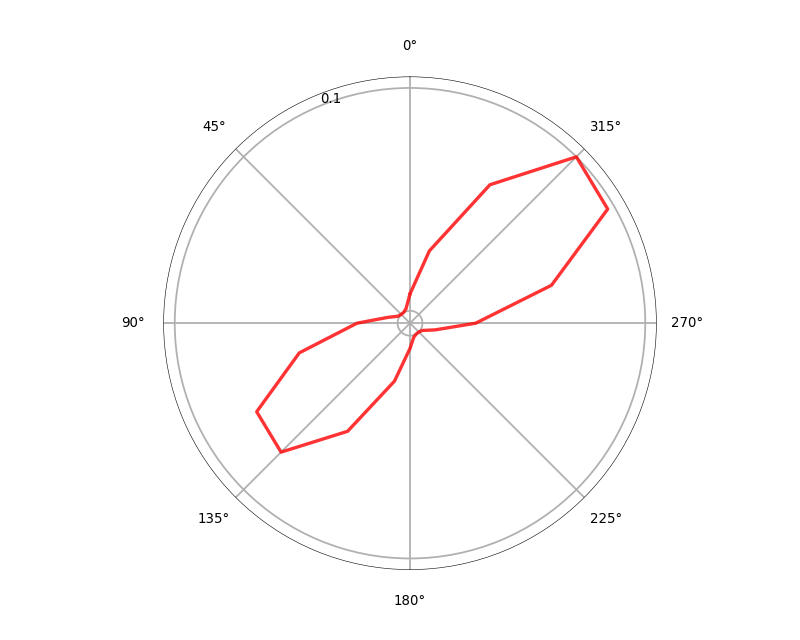

(<Figure size 500x400 with 1 Axes>, <PolarAxesSubplot:>)

In [120]:
fig = pl.figure()
ax =fig.add_subplot(projection='polar')
gutils.plot_tuning_polar_roi(thetas_interp, fitr, curr_sems=None, 
                response_type=response_type,
                fig=fig, ax=ax, color='r', linestyle='-', alpha=0.8,
                label='gof %.2f\ndff %.2f' % (gof, origr.max()) )

In [ ]:
thetas = np.array([np.deg2rad(c) for c in curr_oris])
radii = curr_resps.copy()


# Get counts of unique datasets

In [29]:
# Unique datasets, get dsets with most ncells pass
min_ncells=5
drop_repeats=True
counts = gdata[gdata['gof']>=gof_thr][['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area', 'datakey']).count().reset_index()
counts = counts[counts['cell']>=min_ncells]
counts = p3.split_datakey(counts)
unique_dsets = p3.select_best_fovs(counts, criterion='max', colname='cell')
u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
all_dkeys = list([tuple(k) for k in \
                  counts[['visual_area', 'datakey']].drop_duplicates().values])
final_dkeys = u_dkeys if drop_repeats else all_dkeys
dset_str = 'drop_repeats' if drop_repeats else 'all_dsets'

finaldf = pd.concat([g for (va, dk), g in gdata.groupby(['visual_area', 'datakey'])\
          if (va, dk) in final_dkeys])
print(finaldf[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li               177   177
Lm               606   606
V1               662   662


In [30]:
final_counts = finaldf[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
final_counts.index = ['%s_%s' % (va, dk) for (va, dk) \
                      in final_counts[['visual_area', 'datakey']].values]
print("Total N cells:")
print(final_counts.groupby(['visual_area']).sum().reset_index())
print("Total N FOVs:")
print(final_counts['visual_area'].value_counts())

print("N cells, by FOV:")
mean_cnts = final_counts.groupby(['visual_area']).mean().reset_index()
std_cnts = final_counts.groupby(['visual_area']).std().reset_index()
mean_cnts['std'] = std_cnts['cell'].values
print(mean_cnts)

Total N cells:
  visual_area  cell
0          Li   177
1          Lm   606
2          V1   662
Total N FOVs:
Lm    8
Li    7
V1    7
Name: visual_area, dtype: int64
N cells, by FOV:
  visual_area       cell        std
0          Li  25.285714  19.137348
1          Lm  75.750000  48.493740
2          V1  94.571429  23.922494


#### Direction selective cells, combine across conds

In [31]:
gof_thr=0.50
min_dsi=0.2
dir_selective = finaldf[(finaldf['gof']>=gof_thr) & (finaldf['dsi']>=min_dsi)].copy()
dsi_counts = dir_selective[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
dsi_counts.index = ['%s_%s' % (va, dk) for (va, dk) \
                      in dsi_counts[['visual_area', 'datakey']].values]
print("N dir-selective cells:")
print(dsi_counts.groupby(['visual_area']).sum().reset_index())

# Get means (across non-ori params)
dir_selective_means = dir_selective.groupby(['visual_area', 'datakey', 'cell'])\
                        .mean().reset_index()

N dir-selective cells:
  visual_area  cell
0          Li    64
1          Lm   235
2          V1   239


#### Axis selective

In [32]:
min_asi = 0.2
axis_selective = finaldf[(finaldf['gof']>=gof_thr) 
                     & (finaldf['dsi']<min_dsi) & (finaldf['asi']>=min_asi)].copy()
asi_counts = axis_selective[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
asi_counts.index = ['%s_%s' % (va, dk) for (va, dk) \
                      in asi_counts[['visual_area', 'datakey']].values]
print("N axis-selective cells:")
print(asi_counts.groupby(['visual_area']).sum().reset_index())

# Get means (across non-ori params)
axis_selective_means = axis_selective.groupby(['visual_area', 'datakey', 'cell'])\
                        .mean().reset_index()
axis_selective_means[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                        .groupby(['visual_area']).count()


N axis-selective cells:
  visual_area  cell
0          Li     6
1          Lm   107
2          V1   168


datakey  cell
visual_area               
Li                 6     6
Lm               107   107
V1               168   168

In [33]:
pass_ = finaldf[finaldf['gof']>=gof_thr][['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
pass_.index = ['%s_%s' % (va, dk) for (va, dk) \
                      in pass_[['visual_area', 'datakey']].values]

In [34]:
## All VISUALLY RESPONSIVE cells:
counts_visual = CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates()\
            .groupby(['visual_area', 'datakey']).count().reset_index()
visual_ = pd.concat([g for (va, dk), g in \
          counts_visual.groupby(['visual_area', 'datakey']) if (va,dk) in final_dkeys])
visual_.index = ['%s_%s' % (va, dk) for (va, dk) \
                      in visual_[['visual_area', 'datakey']].values]
# combog = combine_metrics(g_means)
print(visual_[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates().groupby(['visual_area']).count())

             datakey  cell
visual_area               
Li                 7     7
Lm                 8     8
V1                 7     7


In [35]:
# Add DIR-SELECTIVE to counts
final_counts = final_counts.rename(columns={'cell': 'tuned'})
final_counts['direction_selective'] = dsi_counts['cell']
# Add Axis-SELECTIVE to counts
final_counts['axis_selective'] = asi_counts['cell']
# Add cells that pass GoF thr
final_counts['pass_gof'] = pass_['cell']
# Add all VISUAL
final_counts['visual'] = visual_['cell']

In [36]:
final_counts = final_counts.fillna(0)

<IPython.core.display.Javascript object>


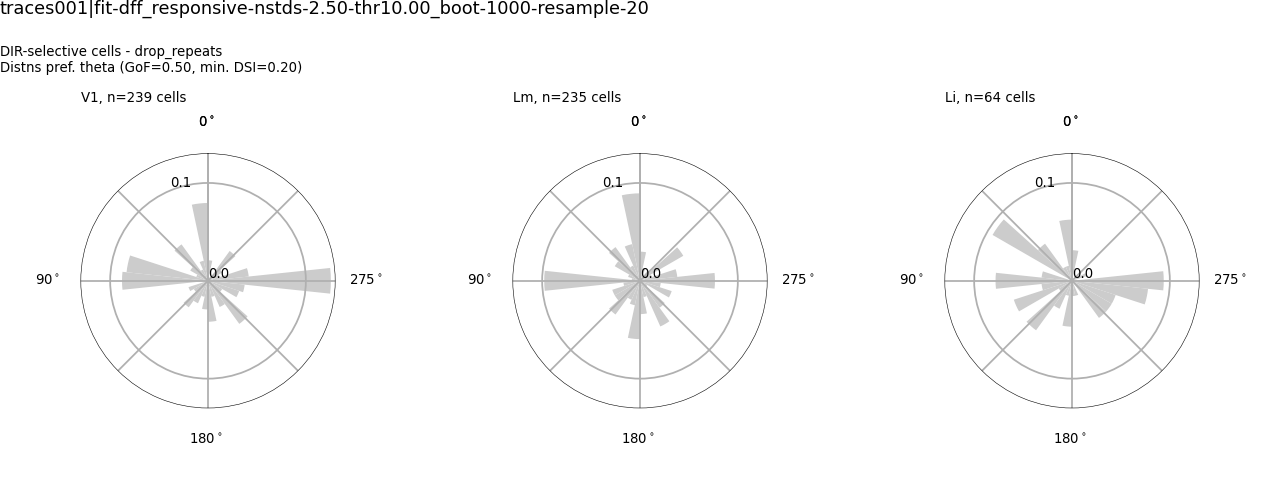

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics _polar_theta_pref_gof0.50_dsi0.20_drop_repeats


In [37]:
metric = 'theta_pref'
bin_size = 12
ai = 1
col='k'
fontsize=6
fig = pl.figure(figsize=(8,3))
for va, vg in dir_selective_means.groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax = fig.add_subplot(1, 3, ai+1, projection="polar")
    degrees = vg[metric].values
    radians = np.array([np.deg2rad(v) for v in degrees])
    # cmean = spstats.circmean(radians, nan_policy='omit')
    weights = np.ones_like(degrees)/len(degrees)
    a , b = np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size),
                        weights=weights)
    centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
    ax.bar(centers, a, width=np.deg2rad(bin_size), 
                   bottom=0.0, color='.8', edgecolor='none')
    # Label angles according to convention
    ax.set_xticks(np.linspace(0, np.pi*2, 9))
    #ax.set_xticks([0, np.pi/2, np.pi, np.pi*(3/2.), np.pi*2])
    #deglabels= [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$0$']
    deglabels = [r'$0^\circ$ ', '', r'$90^\circ$ ', '', r'$180^\circ$ ', '',
                 r'$275^\circ$' ,'',  r'$0^\circ$ ']
    ax.set_xticklabels(deglabels,fontsize=fontsize)
    ax.set_title('%s, n=%i cells' % (va, len(vg)), loc='left', fontsize=fontsize)
    ax.set_theta_zero_location("N")
    ax.set_ylim([0, 0.13])
    ax.set_yticks(np.linspace(0, 0.1, 2))
#ax.legend(bbox_to_anchor=(0, 0), loc='upper left', fontsize=fontsize)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.68, wspace=0.5, hspace=0.75)
fig.text(0.0, 0.85, 'DIR-selective cells - drop_repeats\nDistns pref. theta (GoF=%.2f, min. DSI=%.2f)'\
         % (gof_thr, min_dsi))
p3.label_figure(fig, data_id)

figname = '_polar_%s_gof%.2f_dsi%.2f_%s' % (metric, gof_thr, min_dsi, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


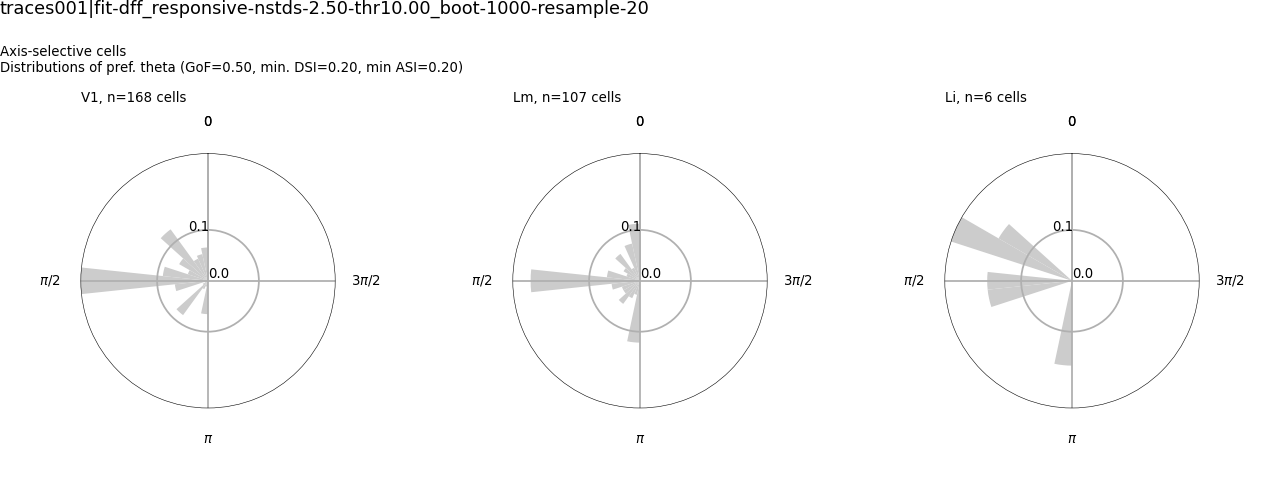

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics _polar_theta_pref_gof0.50_dsi0.20_axis-selective_drop_repeats


In [38]:
metric = 'theta_pref'
bin_size = 12
ai = 1
col='k'
fontsize=6
fig = pl.figure(figsize=(8,3))
for va, vg in axis_selective_means.groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax = fig.add_subplot(1, 3, ai+1, projection="polar")
    degrees = [v % 180. for v in vg[metric].values]
    radians = np.array([np.deg2rad(v) for v in degrees])
    # cmean = spstats.circmean(radians, nan_policy='omit')
    weights = np.ones_like(degrees)/len(degrees)
    a , b = np.histogram(degrees, bins=np.arange(0, 180+bin_size, bin_size),
                        weights=weights)
    centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
    ax.bar(centers, a, width=np.deg2rad(bin_size), 
                   bottom=0.0, color='.8', edgecolor='none')
    # Label angles according to convention
    ax.set_xticks([0, np.pi/2, np.pi, np.pi*(3/2.), np.pi*2])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$0$'],
                      fontsize=fontsize)
    ax.set_title('%s, n=%i cells' % (va, len(vg)), loc='left', fontsize=fontsize)
    ax.set_theta_zero_location("N")
    ax.set_ylim([0, 0.25])
    ax.set_yticks(np.linspace(0, 0.1, 2))
#ax.legend(bbox_to_anchor=(0, 0), loc='upper left', fontsize=fontsize)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.68, wspace=0.5, hspace=0.75)
fig.text(0.0, 0.85, 'Axis-selective cells\nDistributions of pref. theta (GoF=%.2f, min. DSI=%.2f, min ASI=%.2f)'\
         % (gof_thr, min_dsi, min_asi))
p3.label_figure(fig, data_id)

figname = '_polar_%s_gof%.2f_dsi%.2f_axis-selective_%s' % (metric, gof_thr, min_dsi, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [39]:
def combine_metrics(scatdf):
    '''
    Combine ASI/DSI into 1 column for plotting
    '''
    all_cols = [k for k in scatdf.columns if k!='asi']
    sd1 = scatdf[all_cols].copy().rename(columns={'dsi': 'value'})
    sd1['ori_metric'] = 'dsi'
    all_cols = [k for k in scatdf.columns if k!='dsi']
    sd2 = scatdf[all_cols].copy().rename(columns={'asi': 'value'})
    sd2['ori_metric'] = 'asi'
    sd = pd.concat([sd1, sd2], axis=0)
    return sd

In [40]:
# All cells that pass FITNESS:
finaldf_combo = combine_metrics(finaldf)
passg = finaldf_combo[finaldf_combo['gof']>=gof_thr]
passg_means = passg.groupby(['visual_area', 'datakey', 'cell'])\
                        .mean().reset_index()
passg_means[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates().groupby(['visual_area']).count()


datakey  cell
visual_area               
Li                69    69
Lm               286   286
V1               337   337

In [41]:
# # Combine ASI/DSI metrics for plotting, get UNIQUE datasets
# combog_pass = combine_metrics(passg_means)
# curr_counts = combog_pass.groupby(['visual_area', 'datakey']).count().reset_index()
# curr_counts = p3.split_datakey(curr_counts)
# unique_dsets = p3.select_best_fovs(curr_counts, criterion='max', colname='cell')
# u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
# finaldf_pass = pd.concat([g for (va, dk), g in combog_pass.groupby(['visual_area', 'datakey'])\
#           if (va, dk) in u_dkeys])
                     
# finaldf_pass[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()


<IPython.core.display.Javascript object>


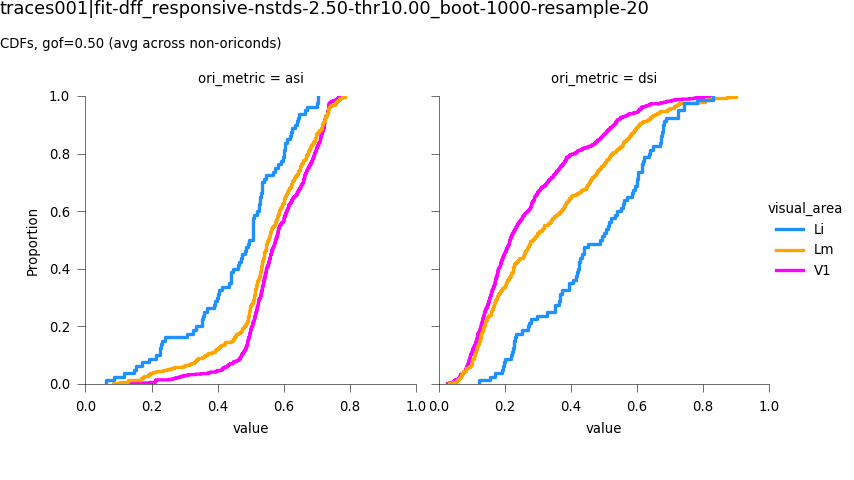

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics _ASI_DSI_all-gof0.50_ecdf_drop_repeats


In [42]:
## Plot distNs of ASI and DSI values

plot_type='ecdf' 
assert plot_type in ['hist', 'ecdf', 'kde']
fg = sns.displot(passg, col='ori_metric', col_order=['asi', 'dsi'],
            x='value', hue='visual_area', palette=area_colors, height=3,
            kind=plot_type, aspect=0.8)
for ax in fg.axes.flat:
    ax.set_xlim([0, 1])
fg.fig.text(0.0, 0.9, 'CDFs, gof=%.2f (avg across non-oriconds)' % gof_thr)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(fg.fig, data_id)
figname = '_ASI_DSI_all-gof%.2f_%s_%s' % (gof_thr, plot_type, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [56]:
passg.groupby(['visual_area', 'tf']).count()

value  response_null  response_offset  response_pref  sigma  \
visual_area tf                                                                  
Li          1.0      76             76               76             76     76   
            2.0      46             46               46             46     46   
            5.0      26             26               26             26     26   
            10.0     12             12               12             12     12   
Lm          1.0     304            304              304            304    304   
            2.0     322            322              322            322    322   
            5.0     144            144              144            144    144   
            10.0    170            170              170            170    170   
V1          1.0     314            314              314            314    314   
            2.0     462            462              462            462    462   
            5.0     130            130              130            130    130   
            10.0    206            206              206            206    206   

                  theta_pref   r2  cell  r2comb  gof   sf  size  speed  \
visual_area tf                                                           
Li          1.0           76   76    76      76   76   76    76     76   
            2.0           46   46    46      46   46   46    46     46   
            5.0           26   26    26      26   26   26    26     26   
            10.0          12   12    12      12   12   12    12     12   
Lm          1.0          304  304   304     304  304  304   304    304   
            2.0          322  322   322     322  322  322   322    322   
            5.0          144  144   144     144  144  144   144    144   
            10.0         170  170   170     170  170  170   170    170   
V1          1.0          314  314   314     314  314  314   314    314   
            2.0          462  462   462     462  462  462   462    462   
            5.0          130  130   130     130  130  130   130    130   
            10.0         206  206   206     206  206  206   206    206   

                  datakey  animalid  fov  session  ori_metric  
visual_area tf                                                 
Li          1.0        76        76   76       76          76  
            2.0        46        46   46       46          46  
            5.0        26        26   26       26          26  
            10.0       12        12   12       12          12  
Lm          1.0       304       304  304      304         304  
            2.0       322       322  322      322         322  
            5.0       144       144  144      144         144  
            10.0      170       170  170      170         170  
V1          1.0       314       314  314      314         314  
            2.0       462       462  462      462         462  
            5.0       130       130  130      130         130  
            10.0      206       206  206      206         206

<IPython.core.display.Javascript object>


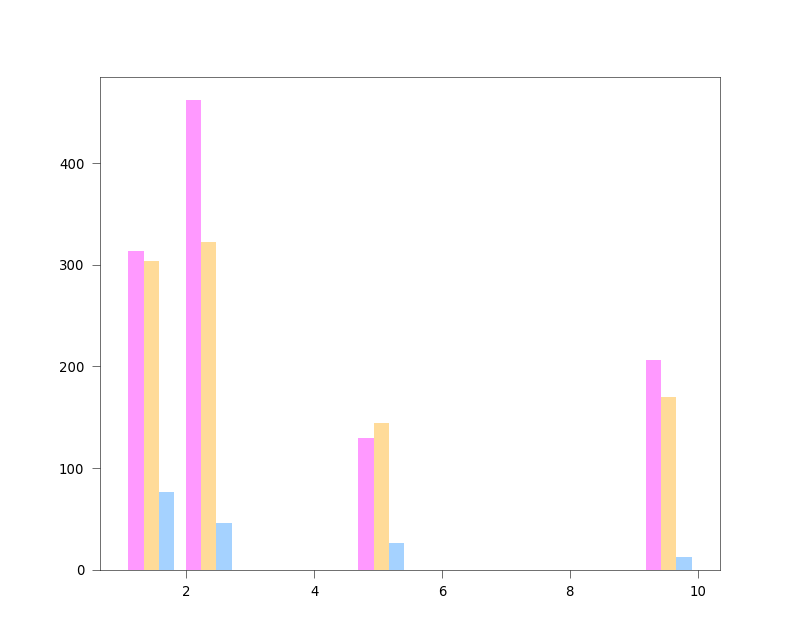

(array([[314., 462.,   0.,   0., 130.,   0.,   0.,   0.,   0., 206.],
        [304., 322.,   0.,   0., 144.,   0.,   0.,   0.,   0., 170.],
        [ 76.,  46.,   0.,   0.,  26.,   0.,   0.,   0.,   0.,  12.]]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 3 BarContainer objects>)

In [77]:

# sns.displot(x='tf', hue='visual_area', data=passg, ax=ax, kind='hist', 
#             palette=area_colors)
binsize=10
fig, ax = pl.subplots()
mats=[]
for va, g in passg.groupby(['visual_area']):
    mats.append(sorted(g['tf'].values))
mat_labels = sorted(passg['tf'].unique())
ax.hist(mats[::-1], binsize, histtype='bar', color=[area_colors[v] for v in visual_areas],
        align='mid', label=visual_areas, alpha=0.4)#, rwidth=0.6)


<IPython.core.display.Javascript object>


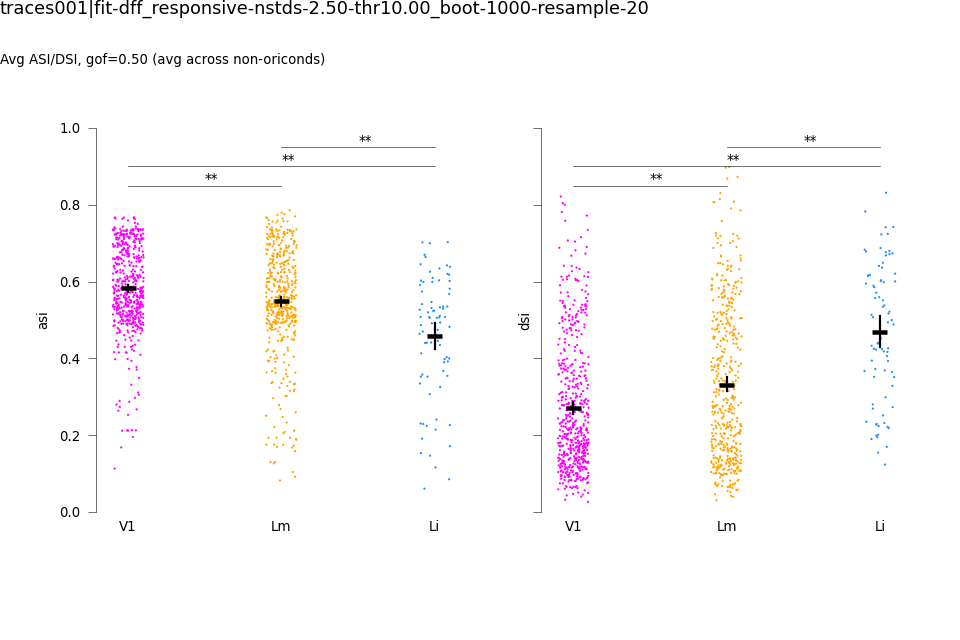

********* [value] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject         p_val     U_val   n1   n2
0  V1  Lm    True  2.576939e-04  114237.0  556  470
1  V1  Li    True  6.116841e-12   11584.0  556   80
2  Lm  Li    True  3.792290e-07   12198.0  470   80
****************************
********* [value] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject         p_val     U_val   n1   n2
0  V1  Lm    True  1.903242e-06  108803.0  556  470
1  V1  Li    True  1.348968e-17    9046.0  556   80
2  Lm  Li    True  3.113005e-09   11076.0  470   80
****************************
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics 0.5


In [43]:
# plot as stripplot
multi_comp_test='fdr_bh'
fig, axn = pl.subplots(1,2, figsize=(6,4), sharex=True, sharey=True)
for ax, (metric, mg) in zip(axn.flat, passg.groupby(['ori_metric'])):
    sns.stripplot(x='visual_area', y='value', data=mg, ax=ax,
                 palette=area_colors, hue='visual_area', order=visual_areas,
                 size=1, zorder=-1)
    sns.pointplot(x='visual_area', y='value', data=mg, ax=ax,
                  order=visual_areas, color='k', join=False, 
                  scale=1, markers='_', errwidth=1, zorder=1000)
    pplot.plot_mannwhitney(mg, metric='value', ax=ax, 
                        multi_comp_test=multi_comp_test,
                        y_loc=0.85, offset=0.05, lw=0.25,fontsize=6)
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    sns.despine(bottom=True, ax=ax)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)
fig.text(0.0, 0.9, 'Avg ASI/DSI, gof=%.2f (avg across non-oriconds)' % gof_thr)

pplot.label_figure(fig, data_id)
figname = '_mean_ASI_DSI_all-gof%.2f_byCELL_%s' % (gof_thr, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, gof_thr)

<IPython.core.display.Javascript object>


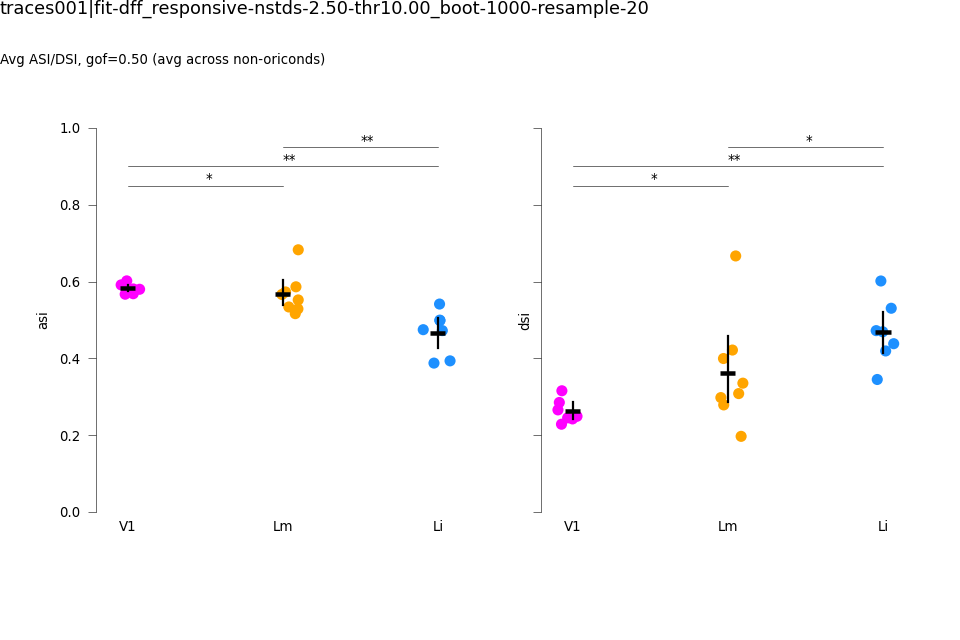

********* [value] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm    True  0.046669   13.0   7   8
1  V1  Li    True  0.003248    0.0   7   7
2  Lm  Li    True  0.003433    3.0   8   7
****************************
********* [value] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm    True  0.028099   11.0   7   8
1  V1  Li    True  0.003248    0.0   7   7
2  Lm  Li    True  0.028099   10.0   8   7
****************************
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics 0.5


In [44]:
# Plot average across cells, per FOV
mean_by_fov = passg.groupby(['visual_area', 'datakey', 'ori_metric']).mean().reset_index()

# plot
multi_comp_test='fdr_bh'
fig, axn = pl.subplots(1,2, figsize=(6,4), sharex=True, sharey=True)
for ax, (metric, mg) in zip(axn.flat, mean_by_fov.groupby(['ori_metric'])):
    sns.stripplot(x='visual_area', y='value', data=mg, ax=ax,zorder=-1,
                 palette=area_colors, hue='visual_area', order=visual_areas)
    sns.pointplot(x='visual_area', y='value', data=mg, ax=ax,
                  order=visual_areas, color='k', join=False, zorder=1000,
                 markers='_', errwidth=1)
    pplot.plot_mannwhitney(mg, metric='value', ax=ax, 
                        multi_comp_test=multi_comp_test,
                        y_loc=0.85, offset=0.05, lw=0.25,fontsize=6)
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    sns.despine(bottom=True, ax=ax)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)
fig.text(0.0, 0.9, 'Avg ASI/DSI, gof=%.2f (avg across non-oriconds)' % gof_thr)

pplot.label_figure(fig, data_id)
figname = '_mean_ASI_DSI_all-gof%.2f_byFOV_%s' % (gof_thr, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, gof_thr)

In [45]:
final_counts['fraction_asi'] = final_counts['axis_selective']/final_counts['tuned']
final_counts['fraction_dsi'] = final_counts['direction_selective']/final_counts['tuned']

final_counts['fraction_tuned'] = final_counts['tuned']/final_counts['visual']
final_counts['fraction_gof'] = final_counts['pass_gof']/final_counts['visual']

<IPython.core.display.Javascript object>


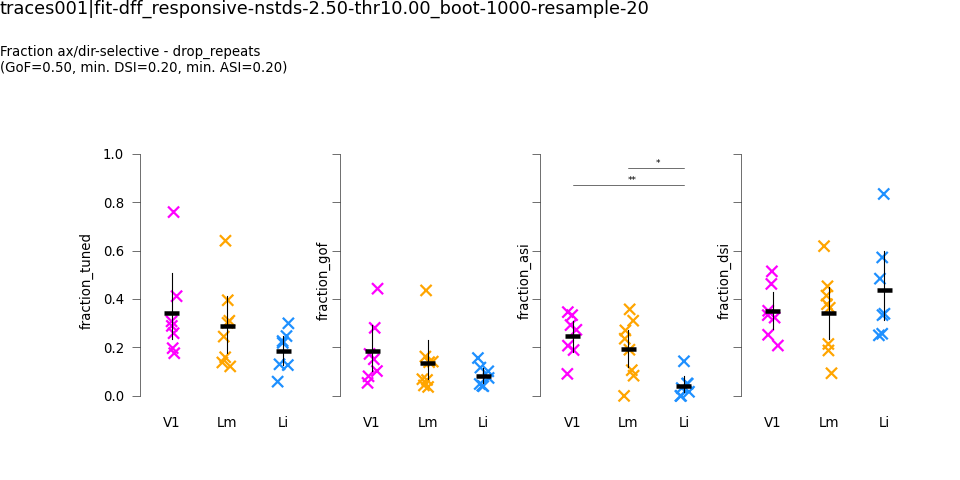

********* [fraction_tuned] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.262225   22.0   7   8
1  V1  Li   False  0.110457   10.0   7   7
2  Lm  Li   False  0.137425   16.0   8   7
****************************
********* [fraction_gof] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.203692   18.0   7   8
1  V1  Li   False  0.110457   10.0   7   7
2  Lm  Li   False  0.262225   22.0   8   7
****************************
********* [fraction_asi] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.225957   21.0   7   8
1  V1  Li    True  0.004890    1.0   7   7
2  Lm  Li    True  0.017644    8.0   8   7
****************************
********* [fraction_dsi] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.476929   28.0   7   8
1  V1  Li   False  0.393337   18.5   7   

In [46]:
multi_comp_test = 'fdr_bh'
fig, axn = pl.subplots(1,4, sharex=True, sharey=True, figsize=(6,3))
for ax, frac in zip(axn.flat, ['fraction_tuned', 'fraction_gof', 'fraction_asi', 'fraction_dsi']):
    sns.stripplot(x='visual_area', y=frac, data=final_counts, ax=ax,
                  hue='visual_area', palette=area_colors, order=visual_areas,
                 zorder=-1, marker='x', linewidth=1)
    sns.pointplot(x='visual_area', y=frac, data=final_counts, ax=ax,
                  color='k', scale=1, errwidth=0.5, markers='_', order=visual_areas,
                 join=False, zorder=1000)
    ax.legend_.remove()
    ax.set_ylim([-0.05, 1])
    ax.set_yticks(np.linspace(0, 1, 6))
    pplot.plot_mannwhitney(final_counts, metric=frac, ax=ax, 
                        multi_comp_test=multi_comp_test,
                        y_loc=0.8, offset=0.07, lw=0.25,fontsize=4)
    
    sns.despine(bottom=True, offset=2, trim=True, ax=ax)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    
pl.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.68, 
                   wspace=0.2, hspace=0.75)
fig.text(0.0, 0.85, 
        'Fraction ax/dir-selective - %s\n(GoF=%.2f, min. DSI=%.2f, min. ASI=%.2f)'\
         % (dset_str, gof_thr, min_dsi, min_asi))
p3.label_figure(fig, data_id)

figname = '_fraction_seletive_gof%.2f_dsi%.2f_asi%.2f_%s' % (gof_thr, min_dsi, min_asi, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [168]:
os.path.join(dst_dir, 'final_counts.csv')


'/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20'

In [321]:
final_counts
counts_outfile = os.path.join(dst_dir, 'final_counts.csv')
final_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/final_counts.csv


In [181]:
final_counts = p3.split_datakey(final_counts)

In [182]:
final_counts.groupby(['visual_area'])['animalid'].count()

visual_area
Li    7
Lm    8
V1    7
Name: animalid, dtype: int64

In [170]:
final_counts.groupby(['visual_area']).sum()

tuned  direction_selective  fraction_dsi  axis_selective  \
visual_area                                                             
Li             177                   64      3.067360             6.0   
Lm             606                  235      2.721410           107.0   
V1             662                  239      2.443946           168.0   

             fraction_asi  visual  fraction_tuned  pass_gof  fraction_gof  
visual_area                                                                
Li               0.293346     966        1.307810        69      0.580162  
Lm               1.553583    2084        2.310290       286      1.093251  
V1               1.731468    2211        2.398603       337      1.284711

In [175]:
final_counts.groupby(['visual_area'])[['visual', 'tuned', 'pass_gof']].sum()

visual  tuned  pass_gof
visual_area                         
Li              966    177        69
Lm             2084    606       286
V1             2211    662       337

In [179]:
final_counts.groupby(['visual_area'])['datakey'].count()

visual_area
Li    7
Lm    8
V1    7
Name: datakey, dtype: int64

In [176]:
final_counts.groupby(['visual_area'])[['visual', 'tuned', 'pass_gof']].mean()

visual      tuned   pass_gof
visual_area                                  
Li           138.000000  25.285714   9.857143
Lm           260.500000  75.750000  35.750000
V1           315.857143  94.571429  48.142857

In [177]:
final_counts.groupby(['visual_area'])[['visual', 'tuned', 'pass_gof']].std()

visual      tuned   pass_gof
visual_area                                  
Li            87.162683  19.137348   6.202918
Lm            37.109875  48.493740  36.385829
V1           100.670136  23.922494  20.971636

In [111]:
# Separate ASI/DSI again for plotting
finaldf_pass_sep = pd.concat([g for (va, dk), g in passg_means.groupby(['visual_area', 'datakey'])\
                      if (va, dk) in u_dkeys])
finaldf_all_sep = pd.concat([g for (va, dk), g in g_means.groupby(['visual_area', 'datakey'])\
                      if (va, dk) in u_dkeys])

In [149]:
# IDentify axis- and direction-selective cells
min_asi=0.15

dsi_cells = finaldf_pass_sep[finaldf_pass_sep['dsi']>=min_dsi]\
                .groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
asi_cells = finaldf_pass_sep[(finaldf_pass_sep['dsi']<min_dsi) 
                       & (finaldf_pass_sep['asi']>=min_asi)]\
                .groupby(['visual_area', 'datakey'])['cell'].count().reset_index()

#### Calculation fraction of cells by tuning type

In [113]:
responsive_ = finaldf_all_sep.groupby(['visual_area', 'datakey'])['cell']\
                .count().reset_index()
tuned_ = finaldf_pass_sep.groupby(['visual_area', 'datakey'])['cell']\
                .count().reset_index()

print("FOV counts:")
print(responsive_.groupby(['visual_area'])['datakey'].count())

print("Cell counts:")
print(responsive_.groupby(['visual_area']).sum())

FOV counts:
visual_area
Li    12
Lm     9
V1     8
Name: datakey, dtype: int64
Cell counts:
             cell
visual_area      
Li            202
Lm            609
V1            685


In [97]:
import copy
min_ncells=1

In [132]:
responsive0 = responsive_.copy()\
                .rename(columns={'cell': 'visual'}).reset_index(drop=True)
tuned0 = tuned_.copy()\
                .rename(columns={'cell': 'gof'}).reset_index(drop=True)
# Get counts
counts = responsive0.copy()
for (va, dk), g in counts.groupby(['visual_area', 'datakey']):
    pg = tuned0[(tuned0.visual_area==va) & (tuned0.datakey==dk)].copy()
    ncells = 0 if len(pg)==0 else float(pg['gof'])
    counts.loc[g.index, 'gof'] = ncells
    # Get N dsi
    sg = dsi_cells[(dsi_cells.visual_area==va) & (dsi_cells.datakey==dk)].copy()
    ncells = 0 if len(sg)==0 else float(sg['cell'])
    counts.loc[g.index, 'dsi'] = ncells
    # Get N asi
    sg = asi_cells[(asi_cells.visual_area==va) & (asi_cells.datakey==dk)].copy()
    ncells = 0 if len(sg)==0 else float(sg['cell'])
    counts.loc[g.index, 'asi'] = ncells
counts['gof_over_visual'] = counts['gof']/counts['visual'].astype(float)

# exclude old rats bec not verified
excl = copy.copy(old_rats) #['20190314_JC070_fov1', '20190306_JC061_fov2', '20190314_JC070_fov2']
currd =counts[(counts['visual']>=min_ncells) & ~(counts.datakey.isin(excl))].copy()

In [157]:
currd['asi_over_gof'] = currd['asi'] /  currd['gof'] 
currd['dsi_over_gof'] = currd['dsi'] /  currd['gof'] 
currd['asi_over_visual'] = currd['asi'] /  currd['visual'] 
currd['dsi_over_visual'] = currd['dsi'] /  currd['visual'] 

In [158]:
currd.head()

visual_area              datakey  visual   gof   dsi  asi  gof_over_visual  \
0          Li  20190314_JC070_fov1      31  16.0  15.0  1.0         0.516129   
1          Li  20190315_JC070_fov2       6   5.0   5.0  0.0         0.833333   
2          Li  20190319_JC067_fov1       8   2.0   2.0  0.0         0.250000   
3          Li  20190522_JC089_fov1       7   5.0   4.0  1.0         0.714286   
4          Li  20190527_JC092_fov3       6   0.0   0.0  0.0         0.000000   

   fraction_asi  fraction_dsi  asi_over_gof  dsi_over_gof  asi_over_visual  \
0        0.0625        0.9375        0.0625        0.9375         0.032258   
1        0.0000        1.0000        0.0000        1.0000         0.000000   
2        0.0000        1.0000        0.0000        1.0000         0.000000   
3        0.2000        0.8000        0.2000        0.8000         0.142857   
4           NaN           NaN           NaN           NaN         0.000000   

   dsi_over_visual  
0         0.483871  
1         0.833333  
2         0.250000  
3         0.571429  
4         0.000000

In [135]:
responsive0.groupby(['visual_area']).sum()

visual
visual_area        
Li              202
Lm              609
V1              685

In [136]:
tuned0.groupby(['visual_area']).sum()

gof
visual_area     
Li            76
Lm           288
V1           340

In [120]:
76/202., 288./609, 340./685

(0.37623762376237624, 0.4729064039408867, 0.49635036496350365)

In [154]:
plotd

visual_area              datakey  visual    gof    dsi   asi  \
0           Li  20190314_JC070_fov1      31   16.0   15.0   1.0   
5           Li  20190602_JC091_fov1      59   20.0   20.0   0.0   
6           Li  20190612_JC099_fov1      15    5.0    5.0   0.0   
7           Li  20190614_JC091_fov1      39   12.0   10.0   2.0   
9           Li  20191018_JC113_fov1      20    6.0    5.0   1.0   
12          Lm  20190306_JC061_fov2      66   31.0   24.0   7.0   
13          Lm  20190314_JC070_fov2      48   13.0    9.0   4.0   
14          Lm  20190512_JC083_fov1     107   10.0   10.0   0.0   
15          Lm  20190513_JC078_fov1     178  121.0  103.0  18.0   
16          Lm  20190525_JC084_fov1      58   33.0   21.0  12.0   
17          Lm  20190603_JC080_fov1      84   44.0   34.0  10.0   
18          Lm  20190618_JC097_fov1      28   14.0    6.0   8.0   
19          Lm  20190627_JC091_fov1      37   20.0   14.0   6.0   
21          V1  20190511_JC083_fov1     132   77.0   54.0  23.0   
22          V1  20190512_JC083_fov1      23    3.0    3.0   0.0   
23          V1  20190522_JC084_fov1     107   73.0   53.0  20.0   
24          V1  20190613_JC097_fov1      65   34.0   21.0  13.0   
25          V1  20190616_JC097_fov1     111   44.0   25.0  19.0   
26          V1  20190617_JC097_fov1      74   34.0   22.0  12.0   
27          V1  20190622_JC085_fov1      96   54.0   26.0  28.0   
28          V1  20191006_JC110_fov1      77   21.0   15.0   6.0   

    gof_over_visual  fraction_asi  fraction_dsi  
0          0.516129      0.062500      0.937500  
5          0.338983      0.000000      1.000000  
6          0.333333      0.000000      1.000000  
7          0.307692      0.166667      0.833333  
9          0.300000      0.166667      0.833333  
12         0.469697      0.225806      0.774194  
13         0.270833      0.307692      0.692308  
14         0.093458      0.000000      1.000000  
15         0.679775      0.148760      0.851240  
16         0.568966      0.363636      0.636364  
17         0.523810      0.227273      0.772727  
18         0.500000      0.571429      0.428571  
19         0.540541      0.300000      0.700000  
21         0.583333      0.298701      0.701299  
22         0.130435      0.000000      1.000000  
23         0.682243      0.273973      0.726027  
24         0.523077      0.382353      0.617647  
25         0.396396      0.431818      0.568182  
26         0.459459      0.352941      0.647059  
27         0.562500      0.518519      0.481481  
28         0.272727      0.285714      0.714286

<IPython.core.display.Javascript object>


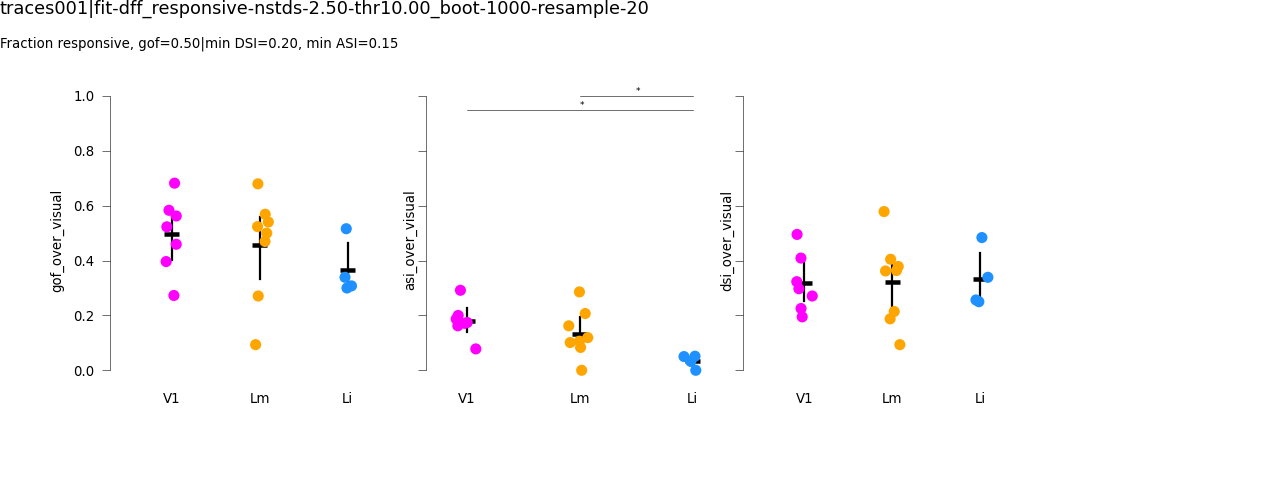

********* [gof_over_visual] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.386169   25.0   7   8
1  V1  Li   False  0.234564    6.0   7   4
2  Lm  Li   False  0.262678   10.0   8   4
****************************
********* [asi_over_visual] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.123369   17.5   7   8
1  V1  Li    True  0.016100    0.0   7   4
2  Lm  Li    True  0.030888    3.5   8   4
****************************
********* [dsi_over_visual] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.476929   28.0   7   8
1  V1  Li   False  0.476929   13.0   7   4
2  Lm  Li   False  0.476929   16.0   8   4
****************************
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics 0.5


In [167]:
plotd = currd[currd['gof']>5].copy()
#plot
fig, axn = pl.subplots(1,3, sharey=True, figsize=(8,3))

for ai, metric in enumerate(['gof_over_visual', 'asi_over_visual', 'dsi_over_visual']):
    ax = axn[ai]
    #sns.barplot(x='visual_area', y='fraction_gof_over_visual', data=currd, ax=ax)
    sns.stripplot(x='visual_area', y=metric, data=plotd, ax=ax,
                 order=visual_areas, hue='visual_area', palette=area_colors)
    sns.pointplot(x='visual_area', y=metric, data=plotd, ax=ax, 
                  join=False,  color='k', order=visual_areas, 
                 markers='_', errwidth=1)
    pplot.plot_mannwhitney(plotd, metric=metric, 
                multi_comp_test='fdr_bh', ax=ax, y_loc=0.9, offset=0.05, 
                lw=0.25, fontsize=4)
    ax.legend_.remove()
    ax.set_ylim([-0.05, 1])
    ax.set_yticks(np.linspace(0, 1, 6))
    sns.despine(bottom=True, offset=8, trim=True, ax=ax)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8)
fig.text(0.0, 0.9, \
         'Fraction responsive, gof=%.2f|min DSI=%.2f, min ASI=%.2f' % (gof_thr, min_dsi, min_asi))

pplot.label_figure(fig, data_id)
figname = 'fraction_selective_gof%.2f' % gof_thr
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, gof_thr)

# Select value at BEST config

In [63]:
gof_thr=0.25
passg = bestg[bestg['gof']>=gof_thr].copy()

<IPython.core.display.Javascript object>


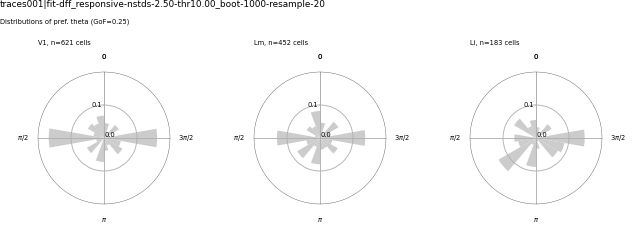

0.0 6.154957035604493
0.0 6.154957035604493
0.0 6.154957035604493
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics polar_theta_pref_noold_gof0.25


In [64]:
metric = 'theta_pref'
bin_size = 20
ai = 1
col='k'
fontsize=6

fig = pl.figure(figsize=(8,3))
for va, vg in passg.groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax = fig.add_subplot(1, 3, ai+1, projection="polar")
    degrees = vg[metric].values
    radians = np.array([np.deg2rad(v) for v in degrees])
    print(radians.min(), radians.max())
    cmean = spstats.circmean(radians, nan_policy='omit')
    
    weights = np.ones_like(degrees)/len(degrees)
    a , b = np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size),
                        weights=weights)
    centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
    ax.bar(centers, a, width=np.deg2rad(bin_size), 
                   bottom=0.0, color='.8', edgecolor='none')
    # Label angles according to convention
    ax.set_xticks([0, np.pi/2, np.pi, np.pi*(3/2.), np.pi*2])
    ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$0$'],
                      fontsize=fontsize)
    ax.set_title('%s, n=%i cells' % (va, len(vg)), loc='left', fontsize=fontsize)
    ax.set_theta_zero_location("N")
    ax.set_ylim([0, 0.2])
    ax.set_yticks(np.linspace(0, 0.1, 2))
#ax.legend(bbox_to_anchor=(0, 0), loc='upper left', fontsize=fontsize)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.7, wspace=0.5, hspace=0.75)
fig.text(0.0, 0.9, 'Distributions of pref. theta (GoF=%.2f)' % gof_thr)
p3.label_figure(fig, data_id)

figname = 'polar_%s_noold_gof%.2f' % (metric, gof_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [66]:
passg.groupby(['visual_area', 'datakey'])['cell'].count()#.groupby('visual_area').sum()

visual_area  datakey            
Li           20190522_JC089_fov1      7
             20190527_JC092_fov3      4
             20190602_JC091_fov1     50
             20190606_JC091_fov1     17
             20190607_JC091_fov1     26
             20190609_JC099_fov1      8
             20190612_JC099_fov1     15
             20190614_JC091_fov1     30
             20190617_JC099_fov1      4
             20191018_JC113_fov1     19
             20191105_JC117_fov1      2
             20191111_JC120_fov1      1
Lm           20190512_JC083_fov1     77
             20190513_JC078_fov1    172
             20190517_JC083_fov1      8
             20190525_JC084_fov1     55
             20190603_JC080_fov1     77
             20190618_JC097_fov1     26
             20190627_JC091_fov1     34
             20191105_JC117_fov1      3
V1           20190511_JC083_fov1    124
             20190512_JC083_fov1     18
             20190517_JC083_fov1      1
             20190522_JC084_fov1    102
       

# Salt N Pepper

In [79]:
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics', 'examples')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples


In [80]:
va='V1'
# dk='20190511_JC083_fov1'
# dk='20190616_JC097_fov1'
dk='20190617_JC097_fov1'
# dk='20190622_JC085_fov1'

# va='Li'
# # dk='20190513_JC078_fov1'
# dk= '20190607_JC091_fov1'
curr_data_id = '%s\n%s_%s' % (data_id, dk, va) #
print(curr_data_id)
zimg, masks, centroids = rutils.get_masks_and_centroids(dk)
# Check masks/centroids
# summed = masks.sum(axis=0)
# fig, ax =pl.subplots()
# ax.imshow(zimg, cmap='gray')
# ax.imshow(summed, cmap='Reds', alpha=0.5)
# sns.scatterplot(x='y', y='x', s=5, data=centroids, ax=ax)

traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
20190617_JC097_fov1_V1


In [81]:
sdf = p3.get_stimuli(dk, 'gratings')
tested_thetas = sorted(np.array(sdf['ori'].unique().astype(float)))
print(dk, tested_thetas)
sdf.head()

20190617_JC097_fov1 [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]


direction luminance  stimtype  xpos ypos aspect ori position speed  \
config007         0      None  gratings  25.0  0.0      1   0  (25, 0)    10   
config006         0      None  gratings  25.0  0.0      1   0  (25, 0)    20   
config005         0      None  gratings  25.0  0.0      1   0  (25, 0)    10   
config004         0      None  gratings  25.0  0.0      1   0  (25, 0)    20   
config003         0      None  gratings  25.0  0.0      1   0  (25, 0)    10   

            sf   size  
config007  0.5  200.0  
config006  0.5   20.0  
config005  0.5   20.0  
config004  0.1  200.0  
config003  0.1  200.0

In [82]:
len(tested_thetas)

8

In [83]:
gof_thr=0#-10000
passg = bestg[bestg['gof']>=gof_thr].copy
passg=bestg.copy()

In [84]:
# sorted(df_['tested_theta'].unique())


In [85]:
currg = passg[(passg.visual_area==va) & (passg.datakey==dk)].copy()
rois_ = sorted(currg['cell'].unique())
print("%i cells pass (gof=%.2f)" % (len(rois_), gof_thr))
currg.index=rois_
df_ = pd.concat([centroids.loc[rois_], currg], axis=1)
df_.shape

74 cells pass (gof=0.00)


(74, 22)

In [86]:
sorted_cells = df_.sort_values(by=['response_pref', 'gof', 'r2comb'], \
                               ascending=False)['cell'].values
sorted_cells[0:10]
plot_rois = list(sorted_cells[0:10])
print(plot_rois)

[280.0, 281.0, 155.0, 291.0, 160.0, 179.0, 22.0, 123.0, 41.0, 87.0]


In [87]:
# import sys
# # !conda install --yes --prefix {sys.prefix} skimage
# !{sys.executable} -m pip install skimage

In [88]:
# from skimage import exposure
# def adjust_grayscale_image(zimg, clip_limit=0.01):
#     '''
#     if float, image must be -1, 1 normalize
#     '''
#     im_adapthist = exposure.equalize_adapthist(zimg, clip_limit=clip_limit)
#     im_adapthist *= 256
#     im_adapthist= im_adapthist.astype('uint8')
#     #ax.imshow(im_adapthist) #pl.figure(); pl.imshow(refRGB) # cmap='gray')
#     orig = im_adapthist.copy()
#     return orig

def adjust_image_contrast(img, clip_limit=2.0, tile_size=10):#(10,10)):
    img[img<-50] = 0
    normed = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    # Convert to 8-bit
    img8 = cv2.convertScaleAbs(normed)

    # Equalize hist:
    tg = tile_size if isinstance(tile_size, tuple) else (tile_size, tile_size)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tg)
    eq = clahe.apply(img8)

    return eq


In [89]:
session, animalid, fovnum = p3.split_datakey_str(dk)
tfs = glob.glob(os.path.join(rootdir, animalid, session, 'FOV%i_*' % fovnum,
                      'gratings_run1', 'processed/processed*', 
                    'mcorrected*_deinterleaved', 'Channel01', 'File*', '*.tif'))
i_=[]
for t in tfs:
    im = tf.imread(t)
    i_.append(im)
imstack = np.dstack(i_)


<IPython.core.display.Javascript object>


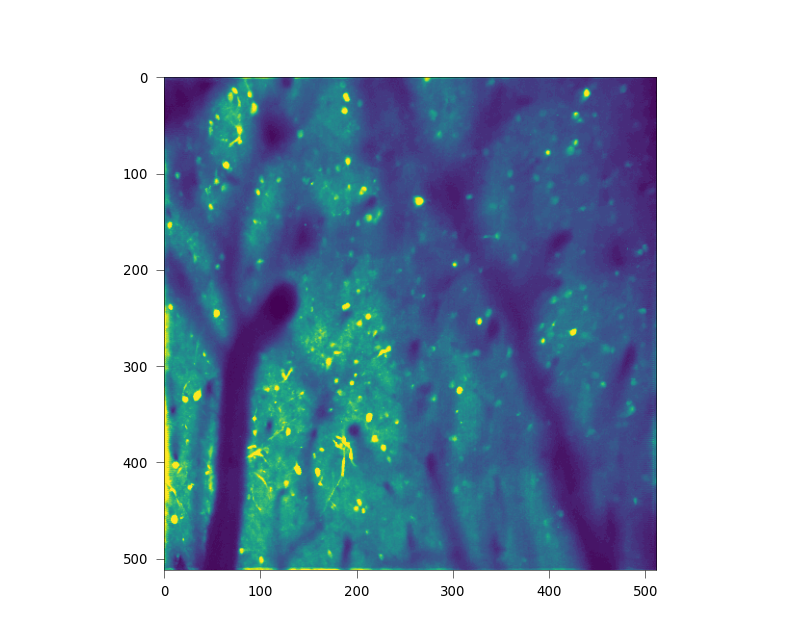

In [90]:
meanr = imstack.mean(axis=-1)
zimg_r = adjust_image_contrast(zimg, clip_limit=2.0, tile_size=5)
pl.figure()
pl.imshow(zimg_r)

<IPython.core.display.Javascript object>


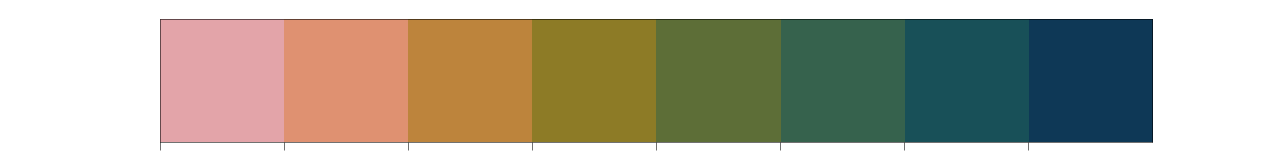

In [91]:
# colormap='cubehelix'
# cmap = mpl.cm.get_cmap(colormap, len(col_values)) # set how many colors you want in color map
colormap = 'batlow' #'nic_Edge'
cmapdir = '/n/coxfs01/julianarhee/colormaps' #os.path.join(aggr_dir, 'colormaps')
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap = mpl.colors.LinearSegmentedColormap.from_list(colormap, cdata[::-1])
# modify colormap
alpha = .9
colors = []
for ind in range(cmap.N):
    c = []
    for x in cmap(ind)[:3]: c.append(x*alpha)
    colors.append(tuple(c))
dark_cmap = mpl.colors.ListedColormap(colors, name='dark_%s' % colormap)
mpl.cm.register_cmap("dark_%s" % colormap, dark_cmap)
# Set colors
ori_colors = sns.color_palette('dark_%s' % colormap, n_colors=len(tested_thetas))
sns.palplot(sns.color_palette('dark_%s' % colormap, n_colors=len(tested_thetas)))


In [92]:
importlib.reload(pplot)

<module 'utils.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/utils/plotting.py'>

<IPython.core.display.Javascript object>


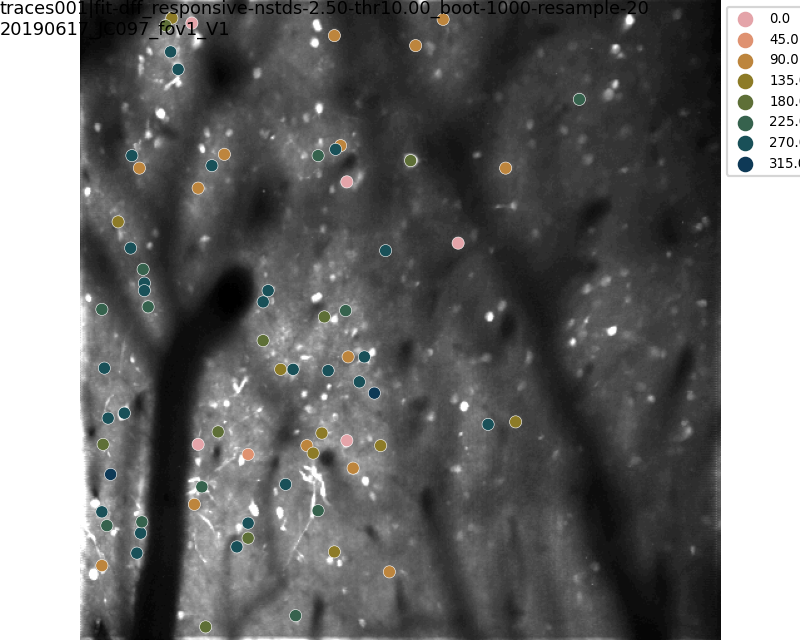

<IPython.core.display.Javascript object>


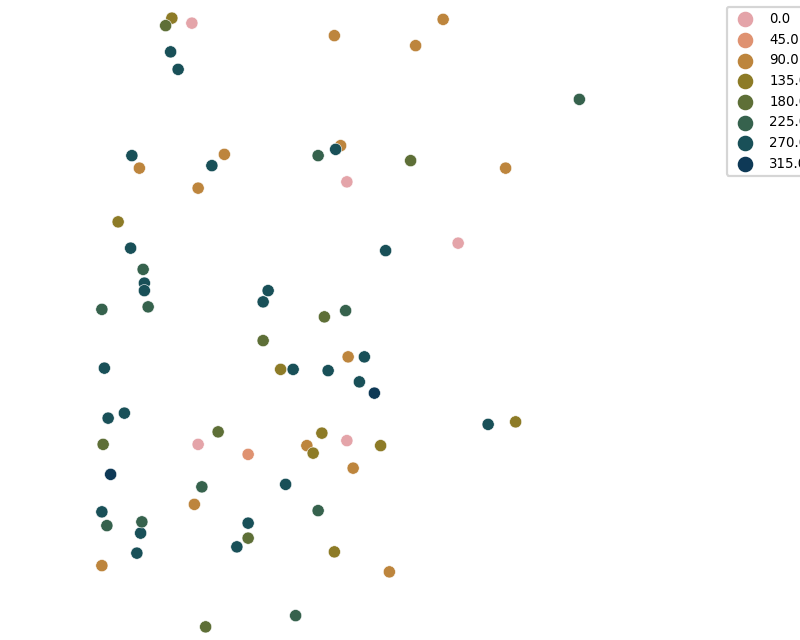

In [204]:
#highlight_rois = [27, 119, 153]
#plot_rois.extend(highlight_rois)
#plot_rois = [16, 17, 66, 91, 116, 165, 204, 215]
#plot_rois = [30, 67, 91, 163, 135, 147,215] # JC084
#plot_rois = [90, 91, 123, 142, 147, 187, 388] # JC097, 20190616
plot_rois=[]
n_actual=len(df_['tested_theta'].unique())
for label_rois in [True, False]:
    #if label_rois is False:
    fig = pl.figure(figsize=(5,4), frameon=False)
    ax = pl.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    ax.imshow(zimg, cmap='gray', alpha=1 if label_rois else 0)
    sns.scatterplot(x='y', y='x', data=df_, ax=ax,
                    hue='tested_theta', palette=ori_colors[0:n_actual], 
                    s=30,linewidth=0.25)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left')
    ax.axis('off')
    if label_rois is True:
        for rid in plot_rois:
            ax.text(df_.loc[rid]['y'], df_.loc[rid]['x'], int(rid), 
                    fontsize=10, color='w')
    if label_rois:
        ax.set_title('gof=%.2f' % gof_thr, fontsize=4, loc='left')
        pplot.label_figure(fig, curr_data_id)
    figname='saltpepper_%s_%s__nobg' % (va, dk) 
    if label_rois:
        figname='%s_labeled' % figname
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


In [146]:
gof_thr

0

<IPython.core.display.Javascript object>


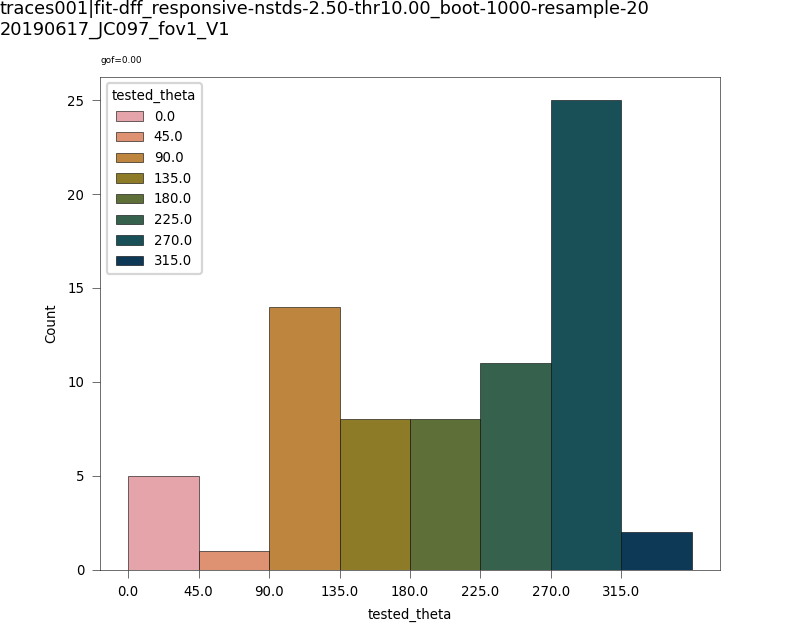

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics preftheta_histbar_V1_20190617_JC097_fov1


In [205]:
fig, ax = pl.subplots()
sns.histplot(x='tested_theta', palette=ori_colors, alpha=1, lw=0.25,
             hue='tested_theta', data=df_, ax=ax, bins=np.arange(0, 360+45, 45))
ax.set_xticks(tested_thetas) #np.arange(0, len(tested_thetas)))
ax.set_xticklabels(tested_thetas)
ax.set_title('gof=%.2f' % gof_thr, fontsize=4, loc='left')

pplot.label_figure(fig, curr_data_id)
figname='preftheta_histbar_%s_%s' % (va, dk) 
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [93]:
np.linspace(0, 360, 9)

array([  0.,  45.,  90., 135., 180., 225., 270., 315., 360.])

In [95]:
experiment='gratings'
session, animalid, fovnum = p3.split_datakey_str(dk)
print(session, animalid, fovnum)

20190617 JC097 1


In [96]:
fitresults, fitparams = gutils.load_tuning_results(dk, fit_desc=ori_fit_desc, traceid=traceid)

g = CELLS[(CELLS.visual_area==va) & (CELLS.datakey==dk)]
g.shape
# Get OSI results
rois_ = g['cell'].unique()
boot_ = dict((k, v) for k, v in fitresults.items() if k in rois_)

In [97]:
dff_traces, labels, sdf = p3.load_traces(animalid, session, fovnum, experiment, 
                traceid=traceid, response_type=response_type,
                responsive_test=responsive_test, responsive_thr=responsive_thr,
                n_stds=n_stds)
dff_traces.head()

0         1         2         3         5         20        21   \
0 -0.059850 -0.076913 -0.025072 -0.126892 -0.325773 -0.077002  0.004512   
1 -0.054731  0.050644  0.015883  0.035610 -0.364852 -0.029520 -0.030707   
2 -0.109366  0.055954 -0.147544  0.077542 -0.336306 -0.005467  0.060920   
3 -0.000364 -0.038872 -0.068967 -0.050531 -0.323488  0.107175 -0.076053   
4 -0.081666  0.049524 -0.033229  0.032627 -0.396479  0.097282 -0.051746   

        22        25        34   ...       324       361       368       377  \
0 -0.023871  0.076139  0.047585  ...  0.114434  0.013686  0.016365  0.013910   
1 -0.099958 -0.004839  0.014009  ...  0.033311  0.029857 -0.022107  0.007870   
2  0.021564  0.018965 -0.000560  ... -0.043046  0.039188  0.119595  0.056234   
3 -0.006171  0.004742 -0.040840  ... -0.094900 -0.118847 -0.081478 -0.050011   
4 -0.145406  0.012701  0.047669  ...  0.049319 -0.049000 -0.020750  0.048310   

        390       396       399       428       430       435  
0  0.001983  0.048927 -0.023566  0.059044 -0.204925 -0.041495  
1 -0.037266  0.070846 -0.005736  0.046949 -0.210180 -0.077081  
2 -0.001522 -0.065982 -0.007820 -0.009689 -0.045336  0.025823  
3  0.046474  0.031842  0.000658 -0.021867  0.097392 -0.010926  
4  0.028206  0.021667  0.056593  0.125210 -0.035762 -0.031923  

[5 rows x 88 columns]

In [98]:
df_['response_pref'].max()

0.36979364541143567

In [99]:
windowsz = 9
smooth_traces = True
plot_trials = True

ymax = 0.2
min_val, max_val = 0, 0

trace_color = 'k'

transform_param = 'ori'
col_values = sorted(sdf[transform_param].unique())

In [100]:
cfg_values = [tuple(c) for c in fitparams['non_ori_configs']]
ori_colors = sns.color_palette(palette='dark_%s' % colormap, n_colors=len(col_values))
print(col_values)
print(cfg_values)
n_conds = len(cfg_values)

[0, 45, 90, 135, 180, 225, 270, 315]
[(0.1, 20.0, 10), (0.1, 20.0, 20), (0.1, 200.0, 10), (0.1, 200.0, 20), (0.5, 20.0, 10), (0.5, 20.0, 20), (0.5, 200.0, 10), (0.5, 200.0, 20)]


In [102]:
plot_rois = [155,262, 280, 399]
plot_roi_list=plot_rois
print(plot_rois)

[155, 262, 280, 399]


## Example traces

In [94]:
def temporal_downsample(trace, windowsz):
    tmp1=np.concatenate((np.ones(windowsz)*trace[0], trace, np.ones(windowsz)*trace[-1]),0)
    tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    tmp2=tmp2[windowsz:-windowsz]
    return tmp2

<IPython.core.display.Javascript object>


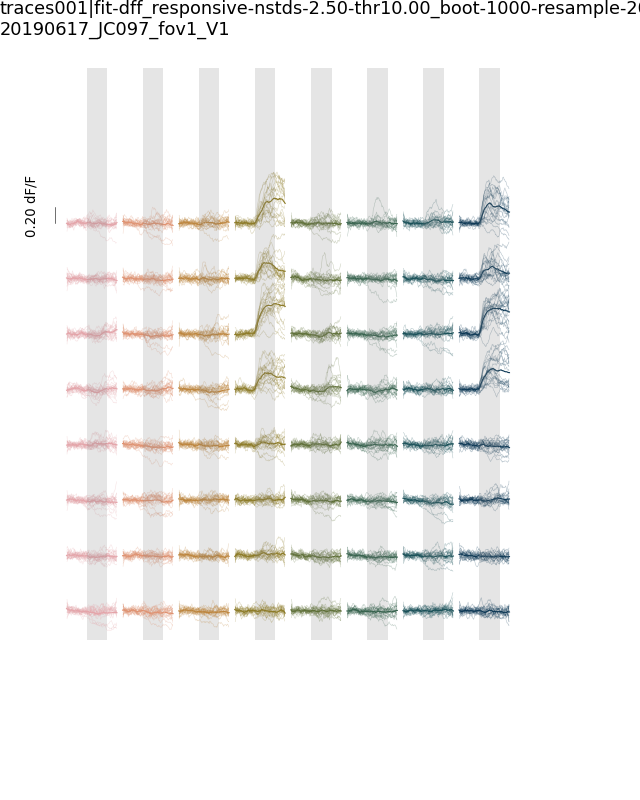

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics traces__V1_20190617_JC097_fov1_rid155


<IPython.core.display.Javascript object>


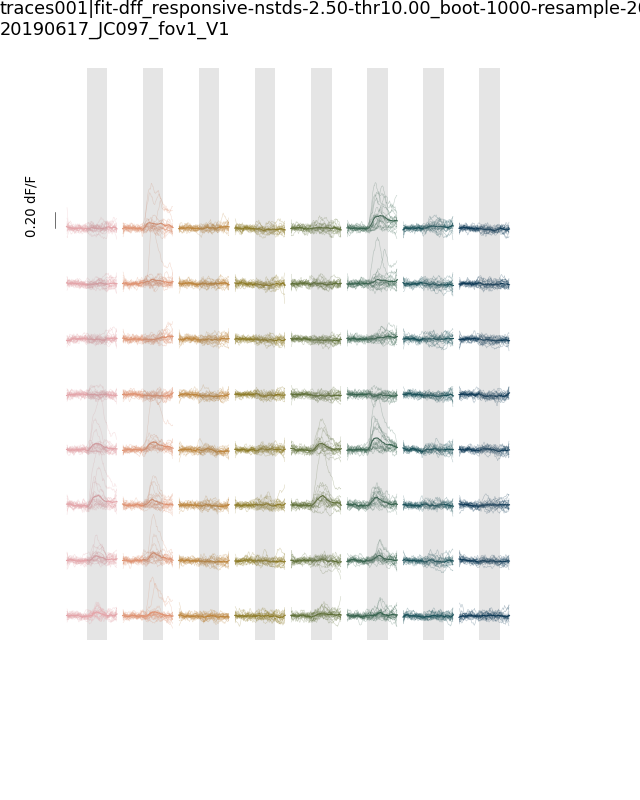

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics traces__V1_20190617_JC097_fov1_rid262


<IPython.core.display.Javascript object>


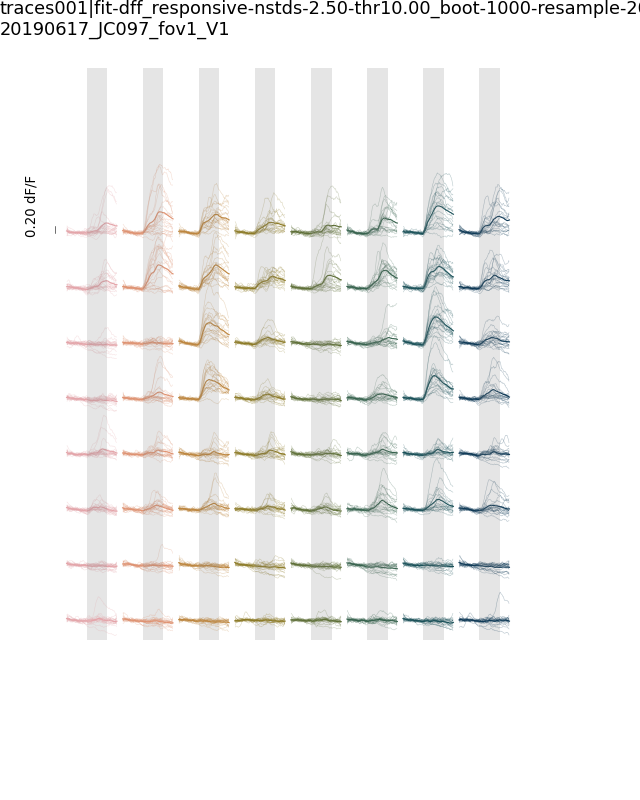

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics traces__V1_20190617_JC097_fov1_rid280


<IPython.core.display.Javascript object>


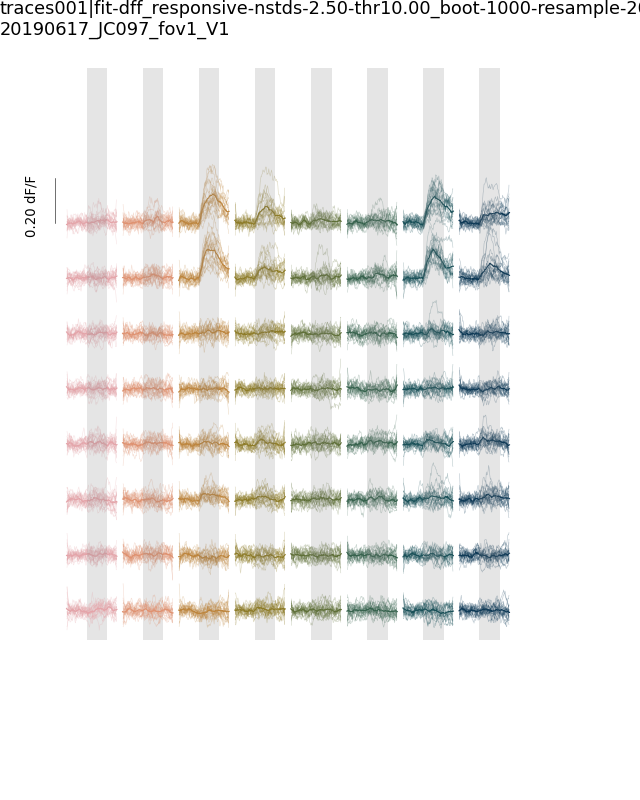

0 (0.1, 20.0, 10)
1 (0.1, 20.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 20.0, 10)
5 (0.5, 20.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics traces__V1_20190617_JC097_fov1_rid399


In [218]:
fontsize=6
n_conds = len(cfg_values)
for rid in plot_roi_list:
    fig, axes = pl.subplots(len(cfg_values), len(col_values), 
                        figsize=(4,5), sharex=False, sharey=True)
    fig.patch.set(alpha=1)
    for ci, cfgv in enumerate(cfg_values):
        condkey = cfgv #tuple([float(i) for i in cfgv.split('-')[1::2]])
        if condkey not in list(boot_[rid].keys()):
            currcfgs = sdf[(sdf['sf']==condkey[0]) 
                         & (sdf['size']==condkey[1]) & (sdf['speed']==condkey[2])].index.tolist()
        else:
            currcfgs = boot_[rid][condkey]['stimulus_configs']
        currlabels = labels[labels['config'].isin(currcfgs)]
        si = cfg_values.index(condkey)
        print(si, condkey)
        for col, (cfg, g) in zip(ori_colors, currlabels.groupby(['config'])):
            currv = sdf[transform_param][cfg] #.copy()
            plot_ix = col_values.index(currv)
            ax = axes[ci, plot_ix]
            ax.patch.set(alpha=0)
            for trial, tdf in g.groupby(['trial']):
                tsec = tdf['tsec'].values
                tvals = dff_traces[rid][tdf.index].values
                st = temporal_downsample(tsec, windowsz) if smooth_traces else tsec
                sm = temporal_downsample(tvals, windowsz) if smooth_traces else tvals
                ax.plot(st, sm, color=col, alpha=0.3, lw=0.25)
            meantrace = np.nanmean(np.array([dff_traces[rid][gg.index] for trial, gg in g.groupby(['trial'])]), axis=0)
            sm = temporal_downsample(meantrace, windowsz) if smooth_traces else meantrace
            ax.plot(tsec, sm, color=col, alpha=1, lw=0.5)

    for ai, ax in enumerate(axes.flat):
        ax.tick_params(which='both', axis='both', length=0)
        if ai == 0:
            ax.set_yticks([0, ymax])
            ax.set_yticklabels(['', ''])
            ax.set_ylabel('%.2f dF/F' % ymax, fontsize=fontsize)
            sns.despine(trim=True, ax=ax, offset=4, bottom=True)
            ax.set_xticklabels([])
        else:
            sns.despine(trim=True, ax=ax, offset=4, left=True, bottom=True)
            ax.set_xticklabels([])
    for ci in range(len(col_values)):
        ax=axes[n_conds-1, ci]
        rect = pl.Rectangle((0,0), width=1, height=(n_conds-2)+fig.subplotpars.wspace,
                         transform=ax.get_xaxis_transform(), clip_on=False, zorder=0,
                         edgecolor="none", facecolor="gray", alpha=0.2, linewidth=0)
        ax.add_patch(rect)
    pl.subplots_adjust(top=0.8, bottom=0.2, left=0.1, right=0.8,hspace=-.4, wspace=0.01)

    pplot.label_figure(fig, curr_data_id)
    figname='traces__%s_%s_rid%i' % ( va, dk, rid) 
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
    print(curr_dst_dir, figname)

In [70]:
cfg_values


[(0.1, 200.0, 20),
 (0.1, 20.0, 20),
 (0.1, 40.0, 20),
 (0.5, 200.0, 20),
 (0.5, 20.0, 20),
 (0.5, 40.0, 20)]

In [1288]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics/examples'

In [270]:
def calculate_signal_correlations(tuning_):
    '''
    tuning_ (pd.DataFrame): nconds x nrois.
    Each entry is the mean response (across trials) for a given stim condition.
    '''
    # Calculate signal corrs
    corrs_ = {}
    rois_ = [i for i in tuning_.columns if p3.isnumber(i)]
    # Get unique pairs, then iterate thru and calculate pearson's CC
    for col_a, col_b in itertools.combinations(rois_, 2):
        corrs_['%i__%i' % (col_a, col_b)] = spstats.pearsonr(tuning_[col_a], tuning_[col_b])
    sigcorrs = pd.DataFrame.from_dict(corrs_, orient='index')
    sigcorrs.columns = ['PCC', 'p-value']
    sigcorrs['cell_1'] = [int(r.split('__')[0]) for r in sigcorrs.index]
    sigcorrs['cell_2'] = [int(r.split('__')[1]) for r in sigcorrs.index]
    
    return sigcorrs

In [275]:
trial_epoch='plushalf'
experiment='gratings'
NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=n_stds)


old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
NDATA = p3.split_datakey(NDATA)
NDATA = NDATA[~NDATA.animalid.isin(old_rats)]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


In [277]:
NDATA[NDATA.visual_area=='Li']['datakey'].unique()

array(['20190522_JC089_fov1', '20190527_JC092_fov3',
       '20190602_JC091_fov1', '20190606_JC091_fov1',
       '20190607_JC091_fov1', '20190609_JC099_fov1',
       '20190612_JC099_fov1', '20190614_JC091_fov1',
       '20190617_JC099_fov1', '20191018_JC113_fov1',
       '20191105_JC117_fov1', '20191111_JC120_fov1'], dtype=object)

In [278]:
SDF={}
for (va, dk), g in NDATA.groupby(['visual_area', 'datakey']):
    sdf = p3.get_stimuli(dk, 'gratings')
    SDF[dk] = sdf

In [279]:
fullSDF = {}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']>50][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    fullSDF[dk] = subset #.append(subset)

In [280]:
apSDF={}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']<100][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    apSDF[dk] = subset #.append(subset)

20190522_JC089_fov1
20190527_JC092_fov3


### Signal corrs

In [282]:
curr_dst_dir = os.path.join(dst_dir, 'aggregate_metrics')
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics


In [283]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

In [284]:
NDATA['experiment'] = 'gratings'
posdf = NDATA[['visual_area', 'datakey', 'experiment', 'cell']].copy()\
        .drop_duplicates().reset_index(drop=True)
# Get ROI positions
posdf = p3.add_rf_positions(posdf)

Adding RF position info...


In [285]:
posdf.shape, posdf.dropna().shape

((1675, 13), (1675, 13))

In [323]:
selective_only=False
stimulus_type='allstim'

assert stimulus_type in ['fullscreen', 'apertured', 'allstim']

if stimulus_type=='fullscreen':
    SD = fullSDF.copy()
elif stimulus_type=='apertured':
    SD = apSDF.copy()
else:
    SD = SDF.copy()
    
roi_filter='gof%.2f' % gof_thr if selective_only else 'allcells'
print(roi_filter)

allcells


In [324]:
c_ = []
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    rois_ = ndf['cell'].unique()
    if len(rois_)<2:
        continue
    if dk not in SD.keys():
        continue
    sdf = SD[dk].copy()
    cfgs = sdf.index.tolist()
    if len(cfgs)==0:
        continue
    ndf = ndf[(ndf.config.isin(cfgs))]
    # Reshape dataframe to ntrials x nrois
    trial_means0 = p3.stacked_neuraldf_to_unstacked(ndf)
    # Zscore trials
    cfgs_by_trial = trial_means0['config']
    if selective_only:
        curr_cells = passg[(passg.visual_area==va) & (passg.datakey==dk)]['cell'].unique()
        if len(curr_cells)<5:
            continue
    else:
        curr_cells = rois_
    trial_means = trial_means0[curr_cells].copy()
    zscored = p3.zscore_dataframe(trial_means)
    zscored['config'] = cfgs_by_trial
    # Get mean reposnse per condition
    tuning_ = zscored.groupby(['config']).mean().reset_index()
    sigcorrs = calculate_signal_correlations(tuning_)
    # Get current FOV rfdata and add position info to sigcorrs df
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    pos_.index = pos_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(pos_.loc[sigcorrs['cell_1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(pos_.loc[sigcorrs['cell_2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    sigcorrs['cortical_distance'] = dists
    sigcorrs['visual_area'] = va
    sigcorrs['datakey'] = dk
    c_.append(sigcorrs)
signal_corrs = pd.concat(c_, axis=0).reset_index(drop=True)


In [325]:
# Bin cortical distances for plotting
n_bins_dist = 10
n_bins_overlap = 8
use_quartile=False
bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    signal_corrs['binned_dist'], bin_edges = pd.qcut(signal_corrs['cortical_distance'], \
                                    n_bins_dist, labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    signal_corrs['binned_dist'], bin_edges = pd.cut(signal_corrs['cortical_distance'], \
                                     n_bins_dist,labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False

binning: eqwidth10


In [326]:
min_n_pairs=10
counts_per_bin = signal_corrs.groupby(['visual_area', 'datakey', 'binned_dist'])\
                    ['PCC'].count().reset_index()
pass_keys = [(va, dk) for (va, dk), g in \
             counts_per_bin[counts_per_bin['PCC']>=min_n_pairs].groupby(['visual_area', 'datakey'])]
CC = pd.concat([g for (va, dk), g in signal_corrs.groupby(['visual_area', 'datakey']) \
               if (va, dk) in pass_keys])
CC.shape, signal_corrs.shape

((90940, 8), (90995, 8))

In [327]:
mean_ccs = CC.groupby(['visual_area', 'datakey', 'binned_dist']).mean().reset_index()

<IPython.core.display.Javascript object>


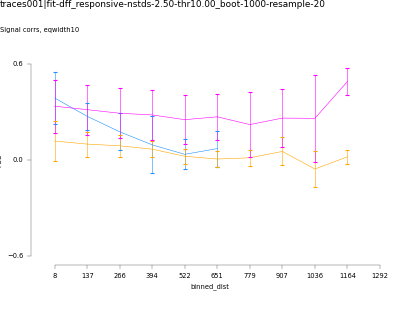

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics sigcorrs_by_dist__allstim_allcells


In [329]:
lw=0.5
metric='PCC'
fig, ax = pl.subplots( figsize=(5,4)) #, sharex=True, sharey=False)
sns.lineplot(x='binned_dist', y=metric, data=mean_ccs, ax=ax,
             hue='visual_area', palette=area_colors, 
             ci='sd', err_style='bars', 
            err_kws={'capsize':2, 'lw': lw}, lw=lw)
ax.set_xticks(list(range(len(bin_edges))))
ax.set_xticklabels([round(i) for i in bin_edges])
ax.set_ylim([-0.6, 0.6])
ax.set_yticks(np.linspace(-0.6, 0.6, 3)) #([-0.6, 0.6])

sns.despine(offset=8, trim=True, ax=ax)
ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.5, hspace=0.5)

p3.label_figure(fig, data_id)
fig.text(0, 0.9, 'Signal corrs, %s' % bin_type)
figname = 'sigcorrs_by_dist__%s_%s' % (stimulus_type, roi_filter)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

## ASI/DSI

In [31]:
def combine_metrics(scatdf):
    all_cols = [k for k in scatdf.columns if k!='asi']
    sd1 = scatdf[all_cols].copy().rename(columns={'dsi': 'value'})
    sd1['ori_metric'] = 'dsi'

    all_cols = [k for k in scatdf.columns if k!='dsi']
    sd2 = scatdf[all_cols].copy().rename(columns={'asi': 'value'})
    sd2['ori_metric'] = 'asi'

    sd = pd.concat([sd1, sd2], axis=0)
    return sd

In [331]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()
combog = combine_metrics(passg)


<IPython.core.display.Javascript object>


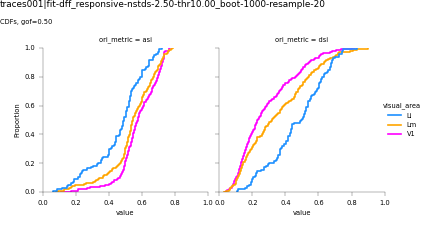

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics 0.5


In [332]:
fg = sns.displot(combog, col='ori_metric', col_order=['asi', 'dsi'],
            x='value', hue='visual_area', palette=area_colors, height=3,
           kind='ecdf', aspect=0.8)
for ax in fg.axes.flat:
    ax.set_xlim([0, 1])
fg.fig.text(0.0, 0.9, 'CDFs, gof=%.2f' % gof_thr)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(fg.fig, data_id)
figname = 'ASI_DSI_gof%.2f_cdf' % gof_thr
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, gof_thr)

In [333]:
gof_thr

0.5

In [338]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()

In [348]:
combog = combine_metrics(passg)
curr_counts = combog.groupby(['visual_area', 'datakey']).count().reset_index()
curr_counts = p3.split_datakey(curr_counts)
unique_dsets = p3.select_best_fovs(curr_counts, criterion='max', colname='cell')
u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
finaldf = pd.concat([g for (va, dk), g in combog.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])

<IPython.core.display.Javascript object>


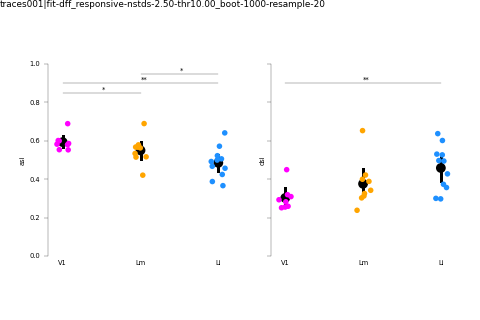

********* [value] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm    True  0.030301   16.0   8   9
1  V1  Li    True  0.006584    9.0   8  11
2  Lm  Li    True  0.030301   24.0   9  11
****************************
********* [value] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.069145   18.0   8   9
1  V1  Li    True  0.006584    9.0   8  11
2  Lm  Li   False  0.085730   31.0   9  11
****************************


In [349]:
meang = finaldf.groupby(['visual_area', 'datakey', 'ori_metric']).mean().reset_index()
# fg = sns.FacetGrid(meang, col='ori_metric', col_order=['asi', 'dsi'], 
#               height=3)

# fg.map(sns.stripplot,'visual_area', 'value', 'visual_area', 
#        palette=area_colors)
# fg.map(sns.pointplot,'visual_area', 'value', join=False, color='k')

multi_comp_test='fdr_bh'
fig, axn = pl.subplots(1,2, figsize=(6,4), sharex=True, sharey=True)
for ax, (metric, mg) in zip(axn.flat, meang.groupby(['ori_metric'])):
    sns.stripplot(x='visual_area', y='value', data=mg, ax=ax,
                 palette=area_colors, hue='visual_area', order=visual_areas)
    sns.pointplot(x='visual_area', y='value', data=mg, ax=ax,
                  order=visual_areas, color='k', join=False)
    pplot.plot_mannwhitney(mg, metric='value', ax=ax, 
                        multi_comp_test=multi_comp_test,
                        y_loc=0.85, offset=0.05, lw=0.25,fontsize=6)
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1])
    sns.despine(bottom=True, ax=ax)
pplot.label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8)

# fig.text(0, 0.9, 'ASI & DSI, Means by FOV (gof=%.2f, mc=%s)' % (gof_thr, multi_comp_test))
# figname = 'ASI_DSI_gof%.2f_byFOV' % gof_thr
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, gof_thr)

## Counts

In [354]:
gdata[gdata.visual_area=='Li']

asi       dsi  response_null  response_offset  response_pref  \
0    0.528705  0.524802       0.025275        -0.010931       0.038352   
1    0.341041  0.685649       0.020652        -0.017558       0.059309   
2    0.590751  0.679958       0.009313        -0.001160       0.027233   
3    0.241354  0.572965       0.024139        -0.021777       0.047835   
4    0.407956  0.362389       0.017694        -0.012919       0.037090   
..        ...       ...            ...              ...            ...   
486  0.527400  0.642588       0.012131        -0.000475       0.025826   
487  0.607651  0.489988       0.009905         0.001922       0.022655   
488  0.543529  0.612775       0.012180        -0.003092       0.033279   
489  0.513413  0.276885       0.110679        -0.047936       0.146132   
490  0.492267  0.356584       0.092938        -0.042156       0.137643   

         sigma  theta_pref        r2   cell    r2comb       gof   sf   size  \
0    52.129545    0.000000  0.727584  160.0  0.365496  0.376922  0.1   60.0   
1    53.811532  132.244898  0.793545  170.0  0.323455  0.397306  0.1   60.0   
2    39.562740  352.653061  0.892822  172.0  0.899031  0.765403  0.1   60.0   
3    69.826945  227.755102  0.671892  177.0  0.660583  0.458513  0.1   60.0   
4    70.338493   80.816327  0.603767  178.0  0.327887  0.230345  0.1   60.0   
..         ...         ...       ...    ...       ...       ...  ...    ...   
486  49.363570  337.959184  0.545497   20.0  0.179227  0.160924  0.5  200.0   
487  35.299134  308.571429  0.566529   20.0  0.209501  0.201317  0.1  200.0   
488  43.136791  132.244898  0.751625   20.0  0.462130  0.431036  0.1  200.0   
489  48.301936  286.530612  0.819210   13.0  0.733408  0.587329  0.1   40.0   
490  48.120976  286.530612  0.833588   13.0  0.813952  0.649592  0.1   40.0   

     speed visual_area              datakey animalid            fov   session  
0     10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314  
1     10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314  
2     10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314  
3     10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314  
4     10.0          Li  20190314_JC070_fov1    JC070  FOV1_zoom2p0x  20190314  
..     ...         ...                  ...      ...            ...       ...  
486   20.0          Li  20191105_JC117_fov1    JC117  FOV1_zoom2p0x  20191105  
487   20.0          Li  20191105_JC117_fov1    JC117  FOV1_zoom2p0x  20191105  
488   10.0          Li  20191105_JC117_fov1    JC117  FOV1_zoom2p0x  20191105  
489   20.0          Li  20191111_JC120_fov1    JC120  FOV1_zoom2p0x  20191111  
490   10.0          Li  20191111_JC120_fov1    JC120  FOV1_zoom2p0x  20191111  

[491 rows x 19 columns]

In [355]:
responsive_ = gdata.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
responsive_.shape

(34, 3)

In [356]:
tuned_ = bestg.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
tuned_.shape

(34, 3)

In [359]:
gof_thr=0.5
passg = bestg[bestg['gof']>=gof_thr].copy()

pass_ = passg.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
pass_.shape

(33, 3)

In [360]:
# d_=[]
# for selector, t in zip(['visual', 'fit', 'gof'], [responsive_, tuned_, pass_]):
#     x = t.copy().rename(columns={'cell': selector}).reset_index(drop=True)
#     d_.append(x)
    
responsive0 = responsive_.copy()\
                .rename(columns={'cell': 'visual'}).reset_index(drop=True)

pass0 = pass_.copy()\
                .rename(columns={'cell': 'gof'}).reset_index(drop=True)
responsive0.head()

visual_area              datakey  visual
0          Li  20190314_JC070_fov1      31
1          Li  20190315_JC070_fov2       6
2          Li  20190319_JC067_fov1       8
3          Li  20190522_JC089_fov1      15
4          Li  20190527_JC092_fov3       7

In [361]:
pass0[(pass0.visual_area==va) & (pass0.datakey==dk)]

visual_area              datakey  gof
32          V1  20191006_JC110_fov1   21

In [364]:
counts = responsive0.copy()
for (va, dk), g in counts.groupby(['visual_area', 'datakey']):
    pg = pass0[(pass0.visual_area==va) & (pass0.datakey==dk)].copy()
    if len(pg)==0:
        ncells = 0
    else:
        ncells = float(pg['gof'])
    counts.loc[g.index, 'gof'] = ncells
# counts['gof'] = pass0['gof'].values
counts['gof_over_visual'] = counts['gof']/counts['visual'].astype(float)


In [365]:
# counts = pd.merge(responsive0, pass0, left_index=True, right_index=True, how='left')
# print(counts.shape)
# counts.head()

In [366]:
import copy

In [367]:
min_ncells=10

In [369]:
excl = copy.copy(old_rats) #['20190314_JC070_fov1', '20190306_JC061_fov2', '20190314_JC070_fov2']
currd =counts[(counts['visual']>=min_ncells) & ~(counts.datakey.isin(excl))].copy()
currd[currd.visual_area=='Lm']

visual_area              datakey  visual    gof  gof_over_visual
15          Lm  20190306_JC061_fov2      66   31.0         0.469697
16          Lm  20190314_JC070_fov2      48   13.0         0.270833
17          Lm  20190512_JC083_fov1     166   10.0         0.060241
18          Lm  20190513_JC078_fov1     531  121.0         0.227872
19          Lm  20190517_JC083_fov1      20    5.0         0.250000
20          Lm  20190525_JC084_fov1     121   33.0         0.272727
21          Lm  20190603_JC080_fov1     171   44.0         0.257310
22          Lm  20190618_JC097_fov1      62   14.0         0.225806
23          Lm  20190627_JC091_fov1      77   20.0         0.259740

In [370]:
currd

visual_area              datakey  visual    gof  gof_over_visual
0           Li  20190314_JC070_fov1      31   16.0         0.516129
3           Li  20190522_JC089_fov1      15    5.0         0.333333
5           Li  20190602_JC091_fov1     138   20.0         0.144928
6           Li  20190606_JC091_fov1      29    6.0         0.206897
7           Li  20190607_JC091_fov1      67   12.0         0.179104
8           Li  20190609_JC099_fov1      14    4.0         0.285714
9           Li  20190612_JC099_fov1      42    5.0         0.119048
10          Li  20190614_JC091_fov1      79   12.0         0.151899
11          Li  20190617_JC099_fov1      11    3.0         0.272727
12          Li  20191018_JC113_fov1      36    6.0         0.166667
15          Lm  20190306_JC061_fov2      66   31.0         0.469697
16          Lm  20190314_JC070_fov2      48   13.0         0.270833
17          Lm  20190512_JC083_fov1     166   10.0         0.060241
18          Lm  20190513_JC078_fov1     531  121.0         0.227872
19          Lm  20190517_JC083_fov1      20    5.0         0.250000
20          Lm  20190525_JC084_fov1     121   33.0         0.272727
21          Lm  20190603_JC080_fov1     171   44.0         0.257310
22          Lm  20190618_JC097_fov1      62   14.0         0.225806
23          Lm  20190627_JC091_fov1      77   20.0         0.259740
25          V1  20190511_JC083_fov1     321   77.0         0.239875
26          V1  20190512_JC083_fov1      32    3.0         0.093750
28          V1  20190522_JC084_fov1     284   73.0         0.257042
29          V1  20190613_JC097_fov1     146   34.0         0.232877
30          V1  20190616_JC097_fov1     233   44.0         0.188841
31          V1  20190617_JC097_fov1     140   34.0         0.242857
32          V1  20190622_JC085_fov1     231   54.0         0.233766
33          V1  20191006_JC110_fov1     151   21.0         0.139073

<IPython.core.display.Javascript object>


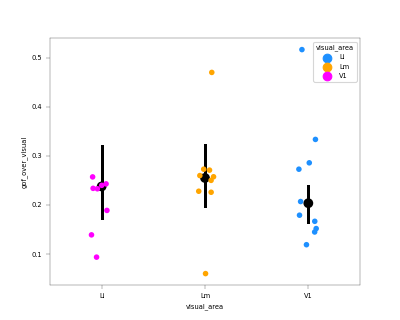

********* [gof_over_visual] Mann-Whitney U test(mc=holm) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.168527   19.0   8   9
1  V1  Li   False  0.624054   36.0   8  10
2  Lm  Li   False  0.624054   38.5   9  10
****************************


(   d1  d2  reject     p_val  U_val  n1  n2
 0  V1  Lm   False  0.168527   19.0   8   9
 1  V1  Li   False  0.624054   36.0   8  10
 2  Lm  Li   False  0.624054   38.5   9  10,
 <AxesSubplot:xlabel='visual_area', ylabel='gof_over_visual'>)

In [371]:

fig, ax = pl.subplots()
#sns.barplot(x='visual_area', y='fraction_gof_over_visual', data=currd, ax=ax)
sns.stripplot(x='visual_area', y='gof_over_visual', data=currd, ax=ax,
             order=visual_areas, hue='visual_area', palette=area_colors)
sns.pointplot(x='visual_area', y='gof_over_visual', data=currd, ax=ax, 
              join=False,  color='k')
pplot.plot_mannwhitney(currd, metric='gof_over_visual', 
            multi_comp_test='holm',
    ax=ax,
    y_loc=0.95,
    offset=0.1,
    lw=0.25,
    fontsize=6)

# Compare with RFs

In [322]:
# Load RF data
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
rf_meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()
rfdata = rfutils.aggregate_rfdata(rf_meta, CELLS, fit_desc=rf_fit_desc)
# Get ROI positions
rfdata = p3.add_rf_positions(rfdata)
rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
rfCELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in rf_dkeys])

N dpaths: 65, N unfit: 0
N datasets included: 65, N sessions excluded: 4
Adding RF position info...


In [323]:
combined_rfs = rfutils.average_rfs_select(rfdata)
df_ = []
for (va, dk), g in combined_rfs.groupby(['visual_area', 'datakey']):
    if va=='Lm':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs'])]
    elif va=='Li':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs10'])]
    else:
        d_ = g.copy()
    df_.append(d_)
rfdf = pd.concat(df_)


In [325]:
RFS=[]
GFS=[]
for (va, dk), gr_ in bestg.groupby(['visual_area', 'datakey']):
    rfs_ = rfdf[(rfdf['visual_area']==va) & (rfdf['datakey']==dk)].copy()
    if len(rfs_)==0:
        continue
    rf_cells = rfs_['cell'].unique()
    gr_cells = gr_['cell'].unique()
    common_cells = np.intersect1d(rf_cells, gr_cells)
    print('%s: %i cells in common (%s)' % (va, len(common_cells), dk))
    RFS.append(rfs_[rfs_['cell'].isin(common_cells)])
    GFS.append(gr_[gr_['cell'].isin(common_cells)])
    
RFS = pd.concat(RFS, axis=0).reset_index(drop=True)
GFS = pd.concat(GFS, axis=0).reset_index(drop=True)
print(GFS.shape, RFS.shape)
cols_to_use = RFS.columns.difference(GFS.columns)
DF = pd.merge(GFS, RFS[cols_to_use], left_index=True, right_index=True, how='outer')
print(DF['theta'].min(), DF['theta'].max())
DF['theta_deg'] = np.rad2deg(DF['theta_Mm_c'])
print(DF['theta_deg'].min(), DF['theta_deg'].max())
DF.dropna().groupby(['visual_area']).count()

Li: 0 cells in common (20190522_JC089_fov1)
Li: 5 cells in common (20190527_JC092_fov3)
Li: 35 cells in common (20190602_JC091_fov1)
Li: 6 cells in common (20190606_JC091_fov1)
Li: 9 cells in common (20190607_JC091_fov1)
Li: 1 cells in common (20190609_JC099_fov1)
Li: 3 cells in common (20190612_JC099_fov1)
Li: 14 cells in common (20190614_JC091_fov1)
Li: 1 cells in common (20190617_JC099_fov1)
Li: 4 cells in common (20191018_JC113_fov1)
Li: 0 cells in common (20191105_JC117_fov1)
Li: 0 cells in common (20191111_JC120_fov1)
Lm: 25 cells in common (20190512_JC083_fov1)
Lm: 19 cells in common (20190513_JC078_fov1)
Lm: 4 cells in common (20190517_JC083_fov1)
Lm: 23 cells in common (20190525_JC084_fov1)
Lm: 27 cells in common (20190603_JC080_fov1)
Lm: 3 cells in common (20190618_JC097_fov1)
Lm: 5 cells in common (20190627_JC091_fov1)
V1: 41 cells in common (20190511_JC083_fov1)
V1: 5 cells in common (20190512_JC083_fov1)
V1: 1 cells in common (20190517_JC083_fov1)
V1: 80 cells in common (2

asi  dsi  response_null  response_offset  response_pref  sigma  \
visual_area                                                                   
Li            78   78             78               78             78     78   
Lm           106  106            106              106            106    106   
V1           290  290            290              290            290    290   

             theta_pref   r2  cell  r2comb  ...  std_avg  std_x  std_y  theta  \
visual_area                                 ...                                 
Li                   78   78    78      78  ...       78     78     78     78   
Lm                  106  106   106     106  ...      106    106    106    106   
V1                  290  290   290     290  ...      290    290    290    290   

             theta_Mm_c  theta_Mm_deg  theta_c   x0   y0  theta_deg  
visual_area                                                          
Li                   78            78       78   78   78         78  
Lm                  106           106      106  106  106        106  
V1                  290           290      290  290  290        290  

[3 rows x 48 columns]

In [326]:
#gd =gdata[~gdata['animalid'].isin(old_rats)].copy()
GFS[GFS['visual_area']=='V1'].shape, GFS[GFS['visual_area']=='V1'].dropna().shape

((290, 20), (290, 20))

In [327]:
DF[DF['visual_area']=='V1'].shape, DF[DF['visual_area']=='V1'].dropna().shape

((290, 49), (290, 49))

In [344]:
counts_by_fov = DF[DF['gof']>=0.25].dropna().groupby(['visual_area', 'datakey']).count().reset_index()
counts_by_fov = p3.split_datakey(counts_by_fov)

In [345]:
overall_best = p3.select_best_fovs(counts_by_fov)
overall_best.groupby(['visual_area']).sum()
overall_dkeys = list(tuple(k) for k in overall_best[['visual_area', 'datakey']].values)

finaldf = pd.concat([g for (va,dk), g in DF.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in overall_dkeys])

In [346]:
finaldf.dropna().groupby(['visual_area']).count()

asi  dsi  response_null  response_offset  response_pref  sigma  \
visual_area                                                                   
Li            61   61             61               61             61     61   
Lm           102  102            102              102            102    102   
V1           289  289            289              289            289    289   

             theta_pref   r2  cell  r2comb  ...  std_avg  std_x  std_y  theta  \
visual_area                                 ...                                 
Li                   61   61    61      61  ...       61     61     61     61   
Lm                  102  102   102     102  ...      102    102    102    102   
V1                  289  289   289     289  ...      289    289    289    289   

             theta_Mm_c  theta_Mm_deg  theta_c   x0   y0  theta_deg  
visual_area                                                          
Li                   61            61       61   61   61         61  
Lm                  102           102      102  102  102        102  
V1                  289           289      289  289  289        289  

[3 rows x 48 columns]

In [347]:
finaldf[finaldf['gof']>=0.].groupby(['visual_area']).count()

asi  dsi  response_null  response_offset  response_pref  sigma  \
visual_area                                                                   
Li            61   61             61               61             61     61   
Lm           102  102            102              102            102    102   
V1           289  289            289              289            289    289   

             theta_pref   r2  cell  r2comb  ...  std_avg  std_x  std_y  theta  \
visual_area                                 ...                                 
Li                   61   61    61      61  ...       61     61     61     61   
Lm                  102  102   102     102  ...      102    102    102    102   
V1                  289  289   289     289  ...      289    289    289    289   

             theta_Mm_c  theta_Mm_deg  theta_c   x0   y0  theta_deg  
visual_area                                                          
Li                   61            61       61   61   61         61  
Lm                  102           102      102  102  102        102  
V1                  289           289      289  289  289        289  

[3 rows x 48 columns]

In [348]:
importlib.reload(pplot)

<module 'plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/plotting.py'>

<IPython.core.display.Javascript object>


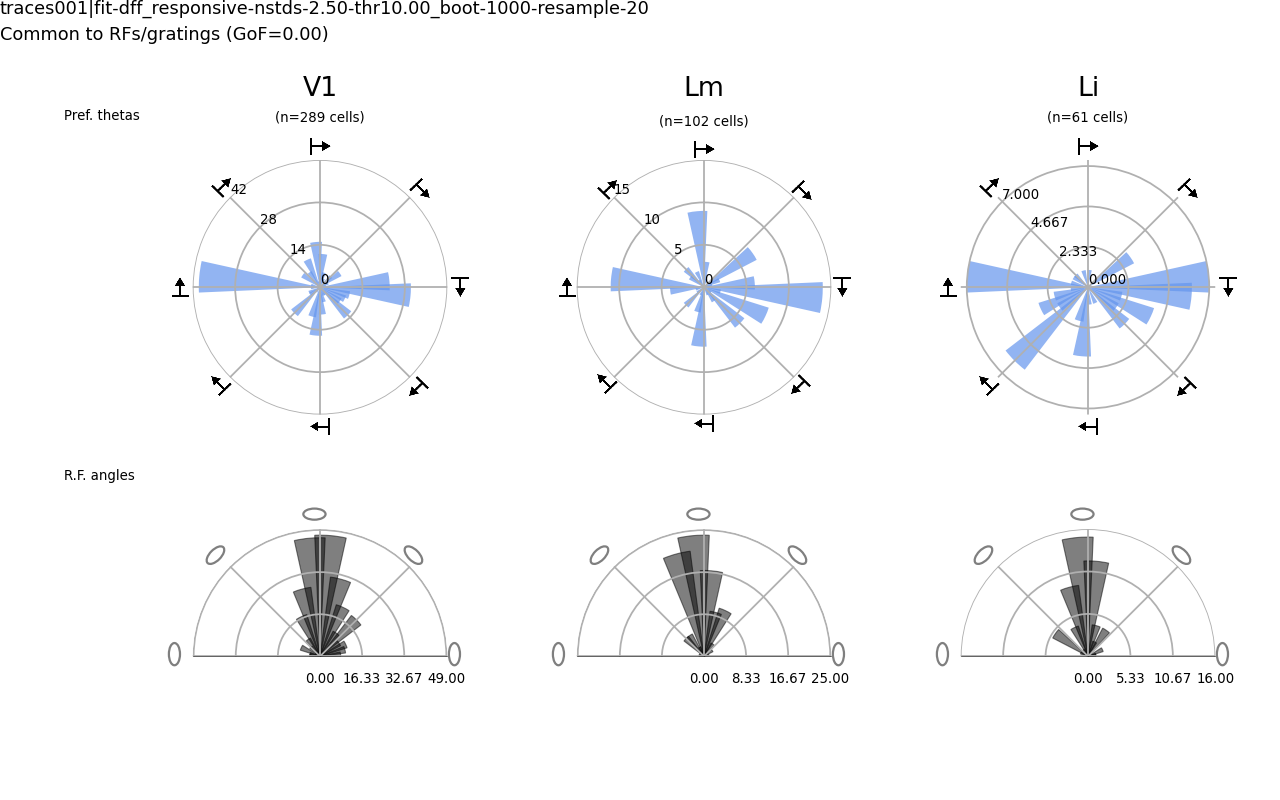

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics polar_theta_v_RFangles__gof0.00_drop_repeats


In [363]:
gof_thr=0.0

plotd = finaldf[finaldf['gof']>=gof_thr].copy().dropna()
rf_color='k'
ori_color='cornflowerblue'
ell_icon_height = 5
alpha=0.5

bar_width=15.
bin_size = 10

max_ori = 360.
ori_bins = np.arange(0, max_ori+bin_size, bin_size)
rf_bins = np.arange(-90, 90+bin_size, bin_size)

rf_names = np.arange(-90, 90+45, 45)
ori_names = np.arange(0, max_ori+45, 45)

fig = pl.figure(figsize=(8,5))
i=0
for vi, visual_area in enumerate(visual_areas):
    g = plotd[plotd['visual_area']==visual_area].copy()
    # First, do PREFERRED THETA
    # --------------------------------------------------------------------
    degrees = g['theta_pref'].values % max_ori #% 180.
    radians = np.rad2deg(degrees)
    bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
               facecolor=ori_color, alpha=0.7, edgecolor="none", 
               color=ori_color, linewidth=0.5)
    ax.set_title('%s' % (visual_area), loc='center', fontsize=12, y=1.2)
    ax.text(ax.get_xlim()[0], ax.get_ylim()[-1]*1.3, 
            '(n=%i cells)' % g.shape[0], fontsize=6, horizontalalignment='center')
    # Set ticks
    # ---------------------------------------------------------------------
    ax.set_theta_zero_location("N")
    ax.set_rlabel_position(45)
    ori_names = np.arange(0, 360, 45) #np.rad2deg(xticks)
    pplot.replace_ori_labels(ori_names, ax=ax, 
                    xybox=(0, 0), yloc=ax.get_ylim()[-1]*1.1, zoom=0.12, polar=True)
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    # Now, do RECEPTIVE FIELD angles
    # ---------------------------------------------------------------------
    degrees = np.rad2deg(g['theta_Mm_c'].values) #. #- 90.
    bin_counts, bin_vals = np.histogram(degrees, bins=rf_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    ax = pl.subplot(2, 3, vi+3+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, 
           color=rf_color, alpha=0.5, edgecolor=rf_color, lw=0.5)
    ax.set_theta_zero_location("N")
    # Set ticks
    # ---------------------------------------------------------------------
    ax.set_xlim([-np.pi/2., np.pi/2.])
    ax.set_xticks(np.arange(-np.pi/2., np.pi/2. + (np.pi/4.), np.pi/4.))
    ax.set_yticks(np.linspace(0, round(ax.get_ylim()[-1]), 4))
    #ax.set_yticklabels([])
    yloc = ax.get_ylim()[-1]*1.1 # + 4
    pplot.replace_rf_labels(rf_names, ax=ax, alpha=alpha,
                    width=ell_icon_height*2., height=ell_icon_height, color='k', 
                    yloc=yloc, lw=1, box_alignment=(1, 1), 
                    xybox=(-ell_icon_height/2., 1))
    i+=2
pplot.label_figure(fig, data_id)
pl.subplots_adjust(left=0.15, wspace=0.5, hspace=0.2, top=0.8,
                   right=0.95, bottom=0.1)

fig.text(0.05, 0.85, "Pref. thetas", horizontalalignment='left', fontsize=6)
fig.text(0.05, 0.4, "R.F. angles", horizontalalignment='left', fontsize=6)
fig.text(0.0, 0.95, "Common to RFs/gratings (GoF=%.2f)" % gof_thr, 
             horizontalalignment='left', fontsize=8)

figname = 'polar_theta_v_RFangles__gof%.2f_%s' % (gof_thr, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [350]:
def split_by_angle(df_, bin_value, metric='theta_Mm_deg', boundary_value=180, bin_size=45, combine_zero=True):
    
    ori_bins = np.arange(-boundary_value, boundary_value+bin_size, bin_size)
        
    #angles = (degs + 180.) % (2*180.) - 180.
    half_bin = bin_size/2.

    if bin_value == -boundary_value:
        bmin = boundary_value - half_bin # 90 - 22.5
        bmax = -boundary_value + half_bin  # -90 + 22.5 
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric]<=bmax]
            #n_in_bin = len(angles[angles<=bmax])
    elif bin_value == boundary_value:
        bmin = boundary_value - half_bin
        bmax = -boundary_value + half_bin
        if combine_zero:
            curr_vs = df_[ (df_[metric] >= bmin) | (df_[metric] <= bmax) ]
            #n_in_bin = len(angles[(angles >= bmin) | (angles<=bmax)])
        else:
            curr_vs = df_[df_[metric] >= bmin]
            #n_in_bin = len(angles[angles>=bmin])
    else:
        bmin = bin_value - half_bin
        bmax = bin_value + half_bin
        curr_vs = df_[ (df_[metric] >= bmin) & (df_[metric] <= bmax) ]
        #n_in_bin = len(angles[(angles >= bmin) & (angles<=bmax)])

    #n_in_bin = np.where([angles<])
    #bin_counts.append(n_in_bin)

    return curr_vs #bin_counts, ori_bins

In [351]:
importlib.reload(pplot)

<module 'plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/plotting.py'>

In [352]:
DF.groupby(['visual_area']).count()

asi  dsi  response_null  response_offset  response_pref  sigma  \
visual_area                                                                   
Li            78   78             78               78             78     78   
Lm           106  106            106              106            106    106   
V1           290  290            290              290            290    290   

             theta_pref   r2  cell  r2comb  ...  std_avg  std_x  std_y  theta  \
visual_area                                 ...                                 
Li                   78   78    78      78  ...       78     78     78     78   
Lm                  106  106   106     106  ...      106    106    106    106   
V1                  290  290   290     290  ...      290    290    290    290   

             theta_Mm_c  theta_Mm_deg  theta_c   x0   y0  theta_deg  
visual_area                                                          
Li                   78            78       78   78   78         78  
Lm                  106           106      106  106  106        106  
V1                  290           290      290  290  290        290  

[3 rows x 48 columns]

<IPython.core.display.Javascript object>


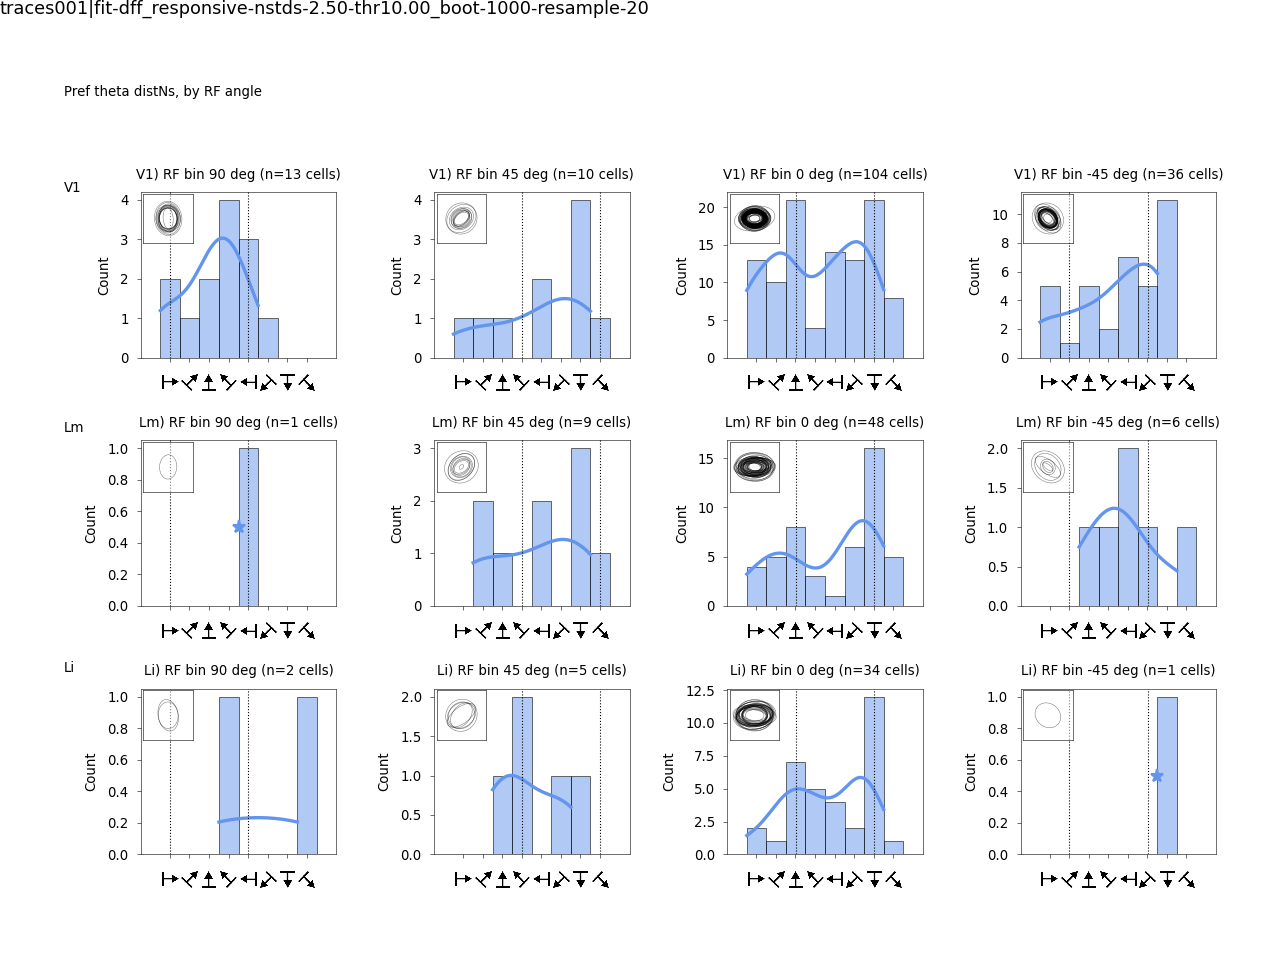

Li:: 78 cells


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Lm:: 106 cells
V1:: 290 cells
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics hist_RFangle_vs_preferredtheta_gof0.00_drop_repeats


In [364]:
rf_color='k'
ori_color='cornflowerblue'

plotd = DF.copy()
yloc=0.5
rf_bin_size = 45
rf_boundary_value = 90 #np.pi/2.
rf_bins = np.arange(-rf_boundary_value, rf_boundary_value + rf_bin_size, rf_bin_size) #% 180.
rf_bin_span=22.5 #22.5 #.5 #22.5
rf_theta_param = 'theta_deg'
##### 
bar_width=30
ori_bin_span=22.5 #2.5 #22.5 #22.5
####
aniso_thr=0.1
filter_aniso=False
max_ori=360.
mod_val=360.
n_bins_dist = 8 if max_ori==360. else 4
ori_bins = np.arange(-180, 180+45, 45)
ori_names = np.arange(0, max_ori+45, 45)
label_unit='degrees'
# =====================================================
# PLOT
# =====================================================
fig, axn = pl.subplots(3, len(rf_bins)-1, figsize=(8,6),sharex=True)
pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8, left=0.11, right=0.95)
offset=0.25
for va, df_ in plotd.groupby(['visual_area']):
    vi = visual_areas.index(va) #vi, va in enumerate(visual_areas):
    #df_ = DF[(DF['visual_area']==va)].copy()
    print('%s:: %i cells' % (va, df_.shape[0]))
    if filter_aniso:
        df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()
    for ci, currbin in enumerate(rf_bins[::-1][0:-1]):   
        # Get all cells with RF angle CURRBIN
        # ---------------------------------------------------------------------
        curr_vs = split_by_angle(df_, currbin, metric=rf_theta_param, boundary_value=rf_boundary_value, 
                                 bin_size=rf_bin_span, combine_zero=True)
        if curr_vs.shape[0]==0:
            continue   
        ncells = curr_vs.shape[0]
        # Calculate distn of prefered OSI 
        # ---------------------------------------------------------------------
        pref_theta_deg = curr_vs['tested_theta'].values % mod_val
        # RF hists of value
        # ---------------------------------------------------------------------
        ax=axn[vi, ci]
        ax.set_title("%s (%i, %i)" % (va, vi, ci))        
        xticks = np.arange(0, mod_val+45, 45)
        if len(pref_theta_deg)==1:
            ax.plot(pref_theta_deg, yloc, color=ori_color, marker='*')
        #ax.hist(pref_theta_deg % mod_val, bins=xticks, align='mid', color='gray', alpha=0.5)
        sns.histplot(pref_theta_deg, ax=ax, bins=n_bins_dist, color=ori_color,
                    kde=True, stat='count', lw=.25, binrange=(0, 360))
#                     discrete=True) #$, ax=ax)
        #cnts, edges = np.histogram(pref_theta_deg, bins=8)
        #bwidth = np.mean(np.diff(edges))/2.
        #most_thetas = edges[cnts.argmax()] +bwidth
        #ax.plot(most_thetas, 0, color='r', marker='^')
        bwidth = np.mean(np.ediff1d(xticks))/2.
        line_loc = ((currbin+90)%360)+bwidth
        ax.axvline(x=line_loc, color='k', lw=0.5, ls=':')
        ax.axvline(x=(line_loc+180)%360., color='k', lw=0.5, ls=':')
        centers = np.ediff1d(xticks)//2 + xticks[:-1]
        ax.set_xticks(centers)
        #ax.set_xticklabels([int(i) for i in xticks], fontsize=4)
        pplot.replace_ori_labels(xticks, bin_centers=centers, ax=ax, xybox=(0, -0.1), 
                           yloc=-0.15, zoom=0.1, polar=False)
        ax.tick_params(which='both', axis='both', labelsize=6, size=2)
        # RF shapes
        # ---------------------------------------------------------------------
        rect = [0.0, 0.69, 0.28, 0.3]
        ax1 = pplot.add_subplot_axes(ax, rect, axisbg='white', axis_alpha=0.5)
        ax1.set_xlim([-12, 12])
        ax1.set_ylim([-12, 12])
        mean_rf_theta = np.rad2deg(np.mean(abs(curr_vs['theta_Mm_c'].values)))
        for ri in curr_vs.index.tolist():
            rv = curr_vs.loc[ri]
            (sz_x, sz_y, th) = rv[['major_axis', 'minor_axis', 'theta_Mm_c']].values
            #(sz_x, sz_y, th) = rv[['std_x', 'std_y', 'theta']].values
            ell = mpl.patches.Ellipse((0, 0), abs(sz_x), abs(sz_y), angle=np.rad2deg(th), edgecolor=rf_color, 
                          facecolor='none', alpha=0.5, lw=0.25)
            ax1.add_patch(ell)
        ax1.set_aspect('equal')
        #ax1.set_title('avg. RF=%.1f deg' % (mean_rf_theta), loc='center', fontsize=6)
        pplot.turn_off_axis_ticks(ax1, despine=False)
        ax.set_title('%s) RF bin %i deg (n=%i cells)' % (va, currbin, ncells), fontsize=6)
        ax.set_xlim([-45, 360+45])
    fig.text(0.05, 0.8-(vi*offset), va)

fig.text(0.05, 0.9, "Pref theta distNs, by RF angle")
pplot.label_figure(fig, data_id)
    
figname = 'hist_RFangle_vs_preferredtheta_gof%.2f_%s' % (gof_thr, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

print(curr_dst_dir, figname)

In [574]:
curr_vs['tested_theta']

195    135.0
208    270.0
210    270.0
218    270.0
223    135.0
226     90.0
227     90.0
236      0.0
240    225.0
242    180.0
244     45.0
261    180.0
262     90.0
264      0.0
273    180.0
274    270.0
278    180.0
282     90.0
285    270.0
313    270.0
314    225.0
315    270.0
322    180.0
327    225.0
331    270.0
334    180.0
340    180.0
348     90.0
376    270.0
386    270.0
393      0.0
399      0.0
401      0.0
415    225.0
429    270.0
466    225.0
Name: tested_theta, dtype: float64

In [535]:
cnts, edges = np.histogram(pref_theta_deg, bins=20)
edges[cnts.argmax()+1]

array([ 3,  1,  0,  0,  3,  2,  0,  1,  1,  1,  4,  3,  2,  2,  1, 10,  0,
        0,  0,  2])

In [536]:
edges[cnts.argmax()+1]

276.2448979591837

# NON ORI PARAM

In [183]:
def index_from_samples(sampled_t, sdf=None, paramnames=['sf', 'size', 'speed']):
    '''
    For resampled df (rows=trials, cols=configs), calculate preference index
    for each parameter (sf, size, speed), where 1=prefers bigger, -1=prefers smaller.
    '''
    tt = sampled_t.T
    for p in paramnames:
        tt[p] = sdf.loc[tt.index][p]
    # Calculate index
    trial_cols = [t for t in tt.columns if t not in paramnames]
    p_ixs={}
    for p in paramnames:
        lo, hi = tt[p].unique().min(), tt[p].unique().max()
        v1 = tt[tt[p]==lo][trial_cols].mean().mean()
        v2 = tt[tt[p]==hi][trial_cols].mean().mean()
        ix = (v2-v1)/(v1+v2) # +1 Bigger preferred, -1 smaller val preferred
        p_ixs.update({p: ix})
    return pd.Series(p_ixs)

def get_trial_df(rd):
    '''
    From stacked neuraldf (1 roi's responses), return NtrialxNconfigs df.
    Add offset for calculating index.
    '''
    # Single value per trial, columns=configs, rows=trial
    trial_vals = pd.concat([pd.Series(g['response'], name=c).reset_index(drop=True)\
                              for c, g in rd.groupby(['config'])], axis=1)
    # Subtract min response (nonneg)
    vmin = trial_vals.min().min()
    if vmin < 0:
        trial_vals = trial_vals - vmin
    return trial_vals

def bootstrap_index_calculation(rd, sdf=None, n_bootstrap_iters=100,
                               paramnames=['sf', 'size', 'speed']):
    '''Resample trials (w replacement), then calculate preference metric '''
    # Single value per trial, columns=configs, rows=trial
    trial_vals = get_trial_df(rd)
    # Resample and calculate index on each (return Niters x 3)
    n_resamples=trial_vals.shape[0]
    iterd = pd.concat([index_from_samples(trial_vals.sample(n_resamples, replace=True), 
                        sdf=sdf, paramnames=paramnames) \
                       for _ in range(n_bootstrap_iters)], axis=1).T
    return iterd

def check_null(iterd, paramnames=['sf', 'size', 'speed'], alpha=95):
    '''
    Given bootstrapped metrics for sf, size, speed, do 2-tailed test for rejecting null,
    i.e., greater or less than 0 or nah.
    '''
    reject_or_no={}
    sf_lo, sz_lo, sp_lo = np.percentile(iterd, (100-alpha)/2, axis=0)
    sf_hi, sz_hi, sp_hi = np.percentile(iterd, alpha+((100-alpha)/2), axis=0)
    paramcis = [(sf_lo, sf_hi), (sz_lo, sz_hi), (sp_lo, sp_hi)]
    for par, ci_ in zip(paramnames, paramcis):
        reject_null = ~(ci_[0] < 0 < ci_[1])
        reject_or_no.update({par: reject_null})
    return pd.Series(reject_or_no)

def bootstrap_and_evaluate_nonori(rd, sdf=None, n_bootstrap_iters=100, alpha=95):
    '''
    Use with groupby.apply() for all cells. Does bootstrap analysis for non-ori
    metrics, then checks for H0 reject or nah
    '''
    iterd = bootstrap_index_calculation(rd, sdf=sdf, 
                            n_bootstrap_iters=n_bootstrap_iters)
    reject_ = check_null(iterd, alpha=alpha)
    #reject_['cell'] = float(rd['cell'].unique())
    return reject_



In [9]:
# def bootstrap_nonori(rd, n_bootstrap_iters=1000):
#     # Single value per trial, columns=configs, rows=trial
#     trial_vals = pd.concat([pd.Series(g['response'], name=c).reset_index(drop=True)\
#                               for c, g in rd.groupby(['config'])], axis=1)
#     # Resample (Nconfigs x Niters)
#     n_resamples=trial_vals.shape[0]
#     bootdf = pd.concat([trial_vals.sample(n_resamples, replace=True)\
#                         .mean(axis=0) for ni in range(n_bootstrap_iters)], axis=1)
#     d_=[]
#     for (sz, sf, sp), g in rd.groupby(['size', 'sf', 'speed']):
#         iter_vals = bootdf.loc[g['config'].unique()].mean(axis=0) # avg across oris
#         df_ = pd.DataFrame(iter_vals, columns=['response'])
#         df_['size'] = sz
#         df_['sf'] = sf
#         df_['speed'] = sp
#         d_.append(df_)
#     iters = pd.concat(d_, axis=0)
#     return iters

# def is_reliable_or_no(rd, iters):
#     reliable_=[]
#     for (sz, sf, sp), g in rd.groupby(['size', 'sf', 'speed']):
#         iter_vs = iters[(iters['size']==sz) & (iters['sf']==sf) & (iters['speed']==sp)]
#         ordered = sorted(iter_vs['response'])
#         ci_lower = np.percentile(ordered, (100-alpha)/2)
#         ci_upper = np.percentile(ordered, alpha+((100-alpha)/2))
#         true_v =float(g['response'].mean())
#         r_val = ci_lower>0 and (ci_lower<true_v<ci_upper)
#         reliable_.append(r_val)
#     return any(reliable_)

# def test_reliable(rd):
#     iters = bootstrap_nonori(rd)
#     is_r = is_reliable_or_no(rd, iters)
#     return is_r

In [184]:
trial_epoch='plushalf'
experiment='gratings'
NDATA = p3.get_aggregate_data(experiment, traceid=traceid, 
                      response_type=response_type, epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr, n_stds=responsive_thr)
old_rats = ['JC061', 'JC067', 'JC070', 'JC073']
NDATA = p3.split_datakey(NDATA)
NDATA = NDATA[~NDATA.animalid.isin(old_rats)]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 3 dsets
['gratings']
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_plushalf.pkl


In [189]:
paramnames = ['size', 'speed', 'sf']
n_bootstrap_iters=100
outfile = os.path.join(curr_dst_dir, 'nonori_params.pkl')
calculate_nonori=False
try:
    with open(outfile, 'rb') as f:
        NON = pkl.load(f)
except Exception as e:
    print("Unable to load saved NON-ori calculations\n%s" % outfile)
    calculate_nonori=True
    

In [190]:
if calculate_nonori:
    R_=[]
    for (va, dk), rdf in NDATA.groupby(['visual_area', 'datakey']):
        sdf = p3.get_stimuli(dk, 'gratings')
        for p in paramnames:
            rdf[p] = sdf.loc[rdf['config']][p].values
        R = rdf.groupby('cell').apply(bootstrap_and_evaluate_nonori, sdf=sdf, 
                                      n_bootstrap_iters=n_bootstrap_iters)
        pass_ = R[R.any(axis=1)]
        pass_['cell'] = pass_.index
        pass_['visual_area'] = va
        pass_['datakey'] = dk
        #reliable_rois = rdf.groupby(['cell']).apply(test_reliable)
        #pass_ = reliable_rois[reliable_rois==True].index.tolist()
        print('%s %s (%i/%i)' % (va,dk, len(pass_), len(rdf['cell'].unique())))
        R_.append(pass_)
    NON = pd.concat(R_, axis=0)
    # save
    with open(outfile, 'wb') as f:
        pkl.dump(NON, f, protocol=2)

In [191]:
NON[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates().groupby(['visual_area']).count()

datakey  cell
visual_area               
Li               225   225
Lm               497   497
V1               791   791

## Caculate preference index for cells that pass

In [192]:
def calculate_nonori_index(rd, param='sf'):
    vmin = rd['response'].min()
    if vmin < 0:
        rd['response'] = rd['response'] - vmin
    lo, hi = rd[param].unique().min(), rd[param].unique().max()
    v1 = rd[rd[param]==lo]['response'].mean() 
    v2 = rd[rd[param]==hi]['response'].mean() 
    ix = (v2-v1)/(v1+v2) # +1 Bigger preferred, -1 smaller val preferred
    return ix #pd.Series(ix) #, index=[rid])

def calculate_nonori_index_all(rd, paramnames=['size', 'speed', 'sf']):
    vmin = rd['response'].min()
    if vmin < 0:
        rd['response'] = rd['response'] - vmin
    p_ixs={}
    for p in paramnames:
        lo, hi = rd[p].unique().min(), rd[p].unique().max()
        v1 = rd[rd[p]==lo]['response'].mean() 
        v2 = rd[rd[p]==hi]['response'].mean() 
        ix = (v2-v1)/(v1+v2) # +1 Bigger preferred, -1 smaller val preferred
        p_ixs.update({p: ix})
    return pd.Series(p_ixs) #, index=[rid])

In [193]:
# def calculate_index_fov(rdf, paramnames=['sf', 'size', 'speed']):
#     x_=[]
#     for param in paramnames:
#         ixs0 = rdf.groupby(['cell']).apply(calculate_nonori_index, param=param)
#         ixs_ = pd.DataFrame(ixs0, columns=['value'])
#         ixs_['metric'] = param
#         ixs_['cell'] = ixs_.index
#         x_.append(ixs_.reset_index(drop=True))
#     curr_ixs = pd.concat(x_, axis=0).reset_index(drop=True)
#     return curr_ixs

def calculate_index_fov(rdf, sdf, param='sf'):
    rdf[param] = sdf.loc[rdf['config']][param].values
    # Get preference index for all cells in FOV that pass
    #ixs_ = calculate_index_fov(rdf, paramnames=paramnames)
    ixs0 = rdf.groupby(['cell']).apply(calculate_nonori_index, param=param)
    ixs_ = pd.DataFrame(ixs0, columns=['value'])
    ixs_['metric'] = param
    ixs_['cell'] = ixs_.index.tolist()
    return ixs_

In [194]:

def aggregate_nonori_index(NDATA, NON, param='sf'):
    i_=[]
    for (va, dk), g in NON.groupby(['visual_area', 'datakey']):
        pass_ = g[g[param]]['cell'].unique()
        rdf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)
                   & (NDATA['cell'].isin(pass_))].copy()
        # Assign stimulus info
        sdf = p3.get_stimuli(dk, 'gratings')
        # Get preference index for all cells in FOV that pass
        ixs_ = calculate_index_fov(rdf, sdf, param=param)
        #ixs_ = rdf.groupby(['cell']).apply(calculate_nonori_index)
        ixs_['visual_area'] = va
        ixs_['datakey'] = dk
        i_.append(ixs_)
    ixs = pd.concat(i_, axis=0)
    return ixs

In [195]:
p_=[]
for param in paramnames:
    param_ixs = aggregate_nonori_index(NDATA, NON, param=param)
    p_.append(param_ixs)
ixs = pd.concat(p_)

In [196]:
ixs.head()

value metric   cell visual_area              datakey
cell                                                      
108     0.0   size  108.0          Li  20190522_JC089_fov1
115     0.0   size  115.0          Li  20190522_JC089_fov1
117     0.0   size  117.0          Li  20190522_JC089_fov1
122     0.0   size  122.0          Li  20190522_JC089_fov1
128     0.0   size  128.0          Li  20190522_JC089_fov1

In [197]:
# Get unique datasets by N cells
curr_counts = ixs[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
curr_counts = p3.split_datakey(curr_counts)
unique_dsets = p3.select_best_fovs(curr_counts, criterion='max', colname='cell')
u_dkeys = list([tuple(k) for k in unique_dsets[['visual_area', 'datakey']].values])
nonori_df = pd.concat([g for (va, dk), g in \
                    ixs.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in final_dkeys])

In [198]:
nonori_df[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates().groupby(['visual_area']).count()

datakey  cell
visual_area               
Li               153   153
Lm               486   486
V1               753   753

In [200]:
nonori_df.head()

value metric   cell visual_area              datakey
cell                                                      
108     0.0   size  108.0          Li  20190522_JC089_fov1
115     0.0   size  115.0          Li  20190522_JC089_fov1
117     0.0   size  117.0          Li  20190522_JC089_fov1
122     0.0   size  122.0          Li  20190522_JC089_fov1
128     0.0   size  128.0          Li  20190522_JC089_fov1

<IPython.core.display.Javascript object>


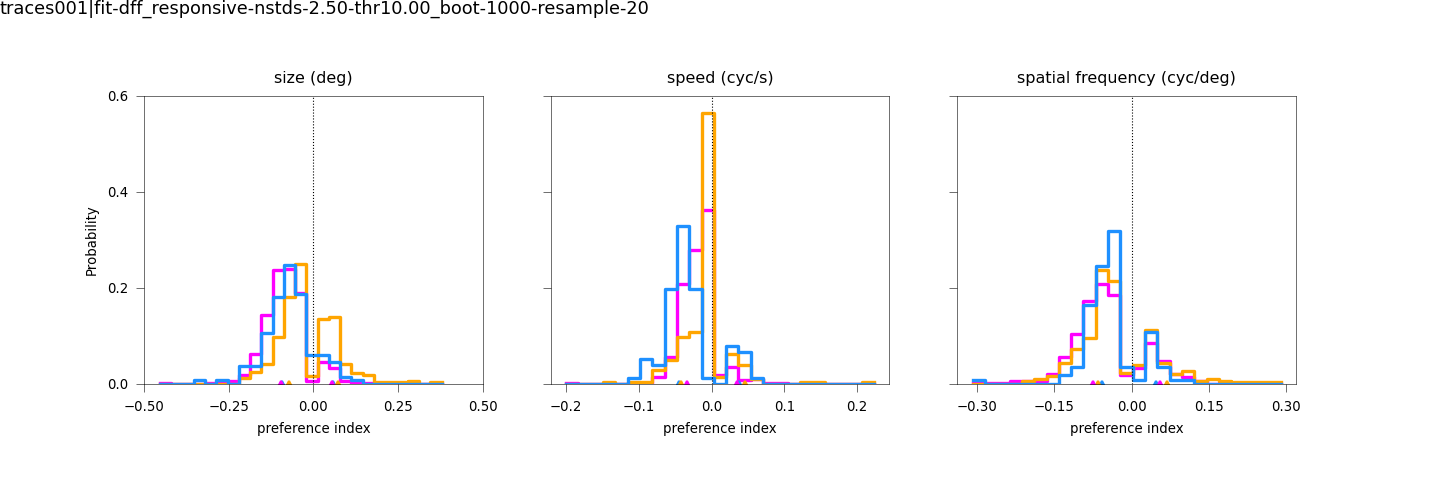

In [304]:
plot_type='stephist'
fig, axn = pl.subplots(1, len(paramnames), sharey=True, figsize=(9,3))
for ax, p in zip(axn.flat, paramnames):
    df_ = nonori_df[nonori_df['metric']==p].copy()
    sns.histplot(x='value', data=df_, 
                 hue='visual_area', palette=area_colors, ax=ax, bins=25,
                  stat='probability', common_norm=False, fill=False,
                element='step')#,
                 #multiple="stack")
    for va, vg in df_.groupby(['visual_area']):
        ax.plot(vg[vg['value']<0]['value'].mean(), -0.0, 
                marker='^', color=area_colors[va], markersize=3)
        ax.plot(vg[vg['value']>0]['value'].mean(), -0.0, marker='^', 
                color=area_colors[va], markersize=3)

    ax.axvline(x=0,color='k', lw=0.5, ls=':')
    ax.set_title(p)
    ax.legend_.remove()
    if p=='size':
        ax.set_title('size (deg)')
        ax.set_xticks(np.linspace(-0.5, 0.5, 5))
    elif p=='speed':
        ax.set_title('speed (cyc/s)')
        ax.set_xticks(np.linspace(-0.2, 0.2, 5))
    else:
        ax.set_title('spatial frequency (cyc/deg)')
        ax.set_xticks(np.linspace(-0.3, 0.3, 5))
    ax.set_ylim((0, 0.6))
    ax.set_yticks(np.linspace(0, 0.6, 4))
    ax.set_yticklabels([round(i, 1) for i in np.linspace(0, 0.6, 4)])
    ax.set_xlabel('preference index')
        
    #sns.despine(trim=True, offset=-2, left=False)
pl.subplots_adjust(bottom=0.2, left=0.1, top=0.8)
pplot.label_figure(fig, data_id)

figname = 'nonori_distns_%s_%s' % (plot_type, dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [269]:
nonori_counts = nonori_df[['visual_area', 'datakey', 'cell', 'metric']].drop_duplicates()\
                    .groupby(['metric', 'visual_area', 'datakey']).count().reset_index()
nonori_counts.index = ['%s_%s' % (va, dk) for (va, dk) \
                      in nonori_counts[['visual_area', 'datakey']].values]

In [271]:
nonori_counts[nonori_counts['metric']=='sf']

metric visual_area              datakey  cell
Li_20190522_JC089_fov1     sf          Li  20190522_JC089_fov1     4
Li_20190602_JC091_fov1     sf          Li  20190602_JC091_fov1    39
Li_20190612_JC099_fov1     sf          Li  20190612_JC099_fov1    17
Li_20190614_JC091_fov1     sf          Li  20190614_JC091_fov1    30
Li_20191018_JC113_fov1     sf          Li  20191018_JC113_fov1    20
Lm_20190512_JC083_fov1     sf          Lm  20190512_JC083_fov1    73
Lm_20190513_JC078_fov1     sf          Lm  20190513_JC078_fov1    83
Lm_20190525_JC084_fov1     sf          Lm  20190525_JC084_fov1    43
Lm_20190603_JC080_fov1     sf          Lm  20190603_JC080_fov1    62
Lm_20190618_JC097_fov1     sf          Lm  20190618_JC097_fov1    17
Lm_20190627_JC091_fov1     sf          Lm  20190627_JC091_fov1    24
V1_20190511_JC083_fov1     sf          V1  20190511_JC083_fov1    91
V1_20190522_JC084_fov1     sf          V1  20190522_JC084_fov1    96
V1_20190613_JC097_fov1     sf          V1  20190613_JC097_fov1    51
V1_20190616_JC097_fov1     sf          V1  20190616_JC097_fov1   106
V1_20190617_JC097_fov1     sf          V1  20190617_JC097_fov1    46
V1_20190622_JC085_fov1     sf          V1  20190622_JC085_fov1    94
V1_20191006_JC110_fov1     sf          V1  20191006_JC110_fov1    71

In [272]:
final_counts['sf_selective'] = nonori_counts[nonori_counts['metric']=='sf']['cell']

final_counts['size_selective'] = nonori_counts[nonori_counts['metric']=='size']['cell']

final_counts['speed_selective'] = nonori_counts[nonori_counts['metric']=='speed']['cell']

In [276]:
final_counts = final_counts.fillna(0)


In [279]:
for p in paramnames:
    final_counts['fraction_%s' % p] = final_counts['%s_selective' % p]/final_counts['visual']
    

In [ ]:
final_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

<IPython.core.display.Javascript object>


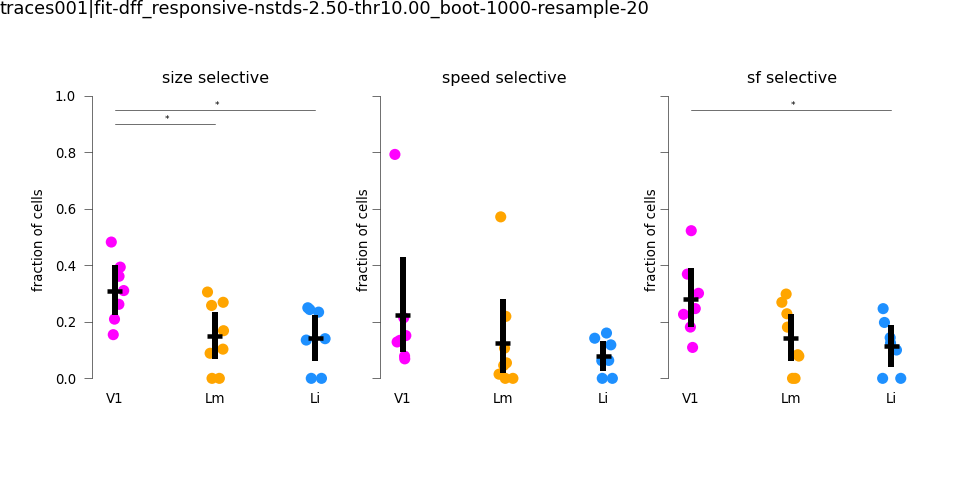

********* [fraction_size] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm    True  0.024092    9.0   7   8
1  V1  Li    True  0.024092    6.0   7   7
2  Lm  Li   False  0.385167   25.0   8   7
****************************
********* [fraction_speed] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.088413   14.0   7   8
1  V1  Li   False  0.088413   11.0   7   7
2  Lm  Li   False  0.430476   26.0   8   7
****************************
********* [fraction_sf] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.054445   12.0   7   8
1  V1  Li    True  0.044493    7.0   7   7
2  Lm  Li   False  0.385167   25.0   8   7
****************************
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics fractioN_nonori_selective_drop_repeats


In [320]:
fig, axn = pl.subplots(1,len(paramnames), figsize=(6,3), sharey=True, sharex=True)
for ax, p in zip(axn.flat, paramnames):
    sns.stripplot(x='visual_area', y='fraction_%s' % p, data=final_counts, ax=ax,
        hue='visual_area', palette=area_colors, order=visual_areas ,zorder=-1)
    sns.pointplot(x='visual_area', y='fraction_%s' % p, data=final_counts, ax=ax,
        color='k', markers='_', scale=1, errwidht=0.5, order=visual_areas, 
                  join=False, zorder=10000)
    pplot.plot_mannwhitney(final_counts, metric='fraction_%s' % p, ax=ax,
                        multi_comp_test=multi_comp_test,
                        y_loc=0.9, offset=0.05, lw=0.25,fontsize=4)
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_title("%s selective" % p)
    ax.set_xlabel('')
    ax.set_ylim([-0.02, 1])
    ax.set_yticks(np.linspace(0, 1, 6))
    sns.despine(bottom=True, trim=True, offset=2)
    ax.set_ylabel("fraction of cells")
pl.subplots_adjust(bottom=0.2, left=0.1, top=0.8, right=0.95) 
pplot.label_figure(fig, data_id)

figname = 'fractioN_nonori_selective_%s' % (dset_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [287]:
final_counts

visual_area              datakey  tuned  \
Li_20190314_JC070_fov1          Li  20190314_JC070_fov1     31   
Li_20190315_JC070_fov2          Li  20190315_JC070_fov2      6   
Li_20190522_JC089_fov1          Li  20190522_JC089_fov1      7   
Li_20190602_JC091_fov1          Li  20190602_JC091_fov1     59   
Li_20190612_JC099_fov1          Li  20190612_JC099_fov1     15   
Li_20190614_JC091_fov1          Li  20190614_JC091_fov1     39   
Li_20191018_JC113_fov1          Li  20191018_JC113_fov1     20   
Lm_20190306_JC061_fov2          Lm  20190306_JC061_fov2     66   
Lm_20190314_JC070_fov2          Lm  20190314_JC070_fov2     48   
Lm_20190512_JC083_fov1          Lm  20190512_JC083_fov1    107   
Lm_20190513_JC078_fov1          Lm  20190513_JC078_fov1    178   
Lm_20190525_JC084_fov1          Lm  20190525_JC084_fov1     58   
Lm_20190603_JC080_fov1          Lm  20190603_JC080_fov1     84   
Lm_20190618_JC097_fov1          Lm  20190618_JC097_fov1     28   
Lm_20190627_JC091_fov1          Lm  20190627_JC091_fov1     37   
V1_20190511_JC083_fov1          V1  20190511_JC083_fov1    132   
V1_20190522_JC084_fov1          V1  20190522_JC084_fov1    107   
V1_20190613_JC097_fov1          V1  20190613_JC097_fov1     65   
V1_20190616_JC097_fov1          V1  20190616_JC097_fov1    111   
V1_20190617_JC097_fov1          V1  20190617_JC097_fov1     74   
V1_20190622_JC085_fov1          V1  20190622_JC085_fov1     96   
V1_20191006_JC110_fov1          V1  20191006_JC110_fov1     77   

                        direction_selective  fraction_dsi  axis_selective  \
Li_20190314_JC070_fov1                   15      0.483871             1.0   
Li_20190315_JC070_fov2                    5      0.833333             0.0   
Li_20190522_JC089_fov1                    4      0.571429             1.0   
Li_20190602_JC091_fov1                   20      0.338983             1.0   
Li_20190612_JC099_fov1                    5      0.333333             0.0   
Li_20190614_JC091_fov1                   10      0.256410             2.0   
Li_20191018_JC113_fov1                    5      0.250000             1.0   
Lm_20190306_JC061_fov2                   24      0.363636             7.0   
Lm_20190314_JC070_fov2                    9      0.187500             4.0   
Lm_20190512_JC083_fov1                   10      0.093458             0.0   
Lm_20190513_JC078_fov1                  110      0.617978            42.0   
Lm_20190525_JC084_fov1                   24      0.413793            18.0   
Lm_20190603_JC080_fov1                   38      0.452381            16.0   
Lm_20190618_JC097_fov1                    6      0.214286            10.0   
Lm_20190627_JC091_fov1                   14      0.378378            10.0   
V1_20190511_JC083_fov1                   61      0.462121            36.0   
V1_20190522_JC084_fov1                   55      0.514019            37.0   
V1_20190613_JC097_fov1                   21      0.323077            19.0   
V1_20190616_JC097_fov1                   28      0.252252            23.0   
V1_20190617_JC097_fov1                   26      0.351351            14.0   
V1_20190622_JC085_fov1                   32      0.333333            32.0   
V1_20191006_JC110_fov1                   16      0.207792             7.0   

                        fraction_asi  visual  fraction_tuned  pass_gof  \
Li_20190314_JC070_fov1      0.032258     137        0.226277        16   
Li_20190315_JC070_fov2      0.000000     102        0.058824         5   
Li_20190522_JC089_fov1      0.142857      32        0.218750         5   
Li_20190602_JC091_fov1      0.016949     197        0.299492        20   
Li_20190612_JC099_fov1      0.000000     118        0.127119         5   
Li_20190614_JC091_fov1      0.051282     299        0.130435        12   
Li_20191018_JC113_fov1      0.050000      81        0.246914         6   
Lm_20190306_JC061_fov2      0.106061     219        0.301370        31   
Lm_20190314_JC070_fov2      0.083333     301        0.159468      

#### Test nonori w/ single FOV

In [193]:
va='V1'
dk ='20190617_JC097_fov1'
# va='Li'
# dk ='20190602_JC091_fov1'
rdf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
sdf = p3.get_stimuli(dk, 'gratings')
# Add stimulus info
for p in paramnames:
    rdf[p] = sdf.loc[rdf['config']][p].values

In [129]:
# Do bootstrap
# R = rdf.groupby('cell').apply(bootstrap_and_evaluate_nonori, sdf=sdf)
# R.head()

sf  size  speed  cell
cell                        
0     0.0   0.0    0.0   0.0
1     0.0   0.0    0.0   1.0
2     1.0   1.0    1.0   2.0
3     0.0   1.0    0.0   3.0
5     0.0   0.0    0.0   5.0

In [131]:
R.loc[rid]

sf         1.0
size       0.0
speed      1.0
cell     155.0
Name: 155, dtype: float64

In [232]:
# x_=[]
# for param in paramnames:
#     ixs0 = rdf.groupby(['cell']).apply(calculate_nonori_index, param=param)
#     ixs_ = pd.DataFrame(ixs0, columns=['value'])
#     ixs_['metric'] = param
#     ixs_['cell'] = ixs_.index
#     x_.append(ixs_.reset_index(drop=True))
# curr_ixs = pd.concat(x_, axis=0)


In [224]:
ixs_ = rdf.groupby(['cell']).apply(calculate_nonori_index, param='size')

In [228]:
rid=280
rd = rdf[rdf['cell']==rid].copy()

In [230]:
param='size'
vmin = rd['response'].min()
if vmin < 0:
    rd['response'] = rd['response'] - vmin
lo, hi = rd[param].unique().min(), rd[param].unique().max()
v1 = rd[rd[param]==lo]['response'].mean() 
v2 = rd[rd[param]==hi]['response'].mean() 
ix = (v2-v1)/(v1+v2) 
print(param, ix)

size -0.09436637992575322


In [177]:
rid = 280 #155
rd = rdf[rdf['cell']==rid].copy()
trial_vals = get_trial_df(rd)
true_ = index_from_samples(trial_vals, sdf=sdf)


In [178]:
iterd = bootstrap_index_calculation(rd, sdf=sdf, 
                        n_bootstrap_iters=n_bootstrap_iters)
reject_ = check_null(iterd, alpha=alpha)
reject_['cell'] = float(rd['cell'].unique())

alpha=95
sf_lo, sz_lo, sp_lo = np.percentile(iterd, (100-alpha)/2, axis=0)
sf_hi, sz_hi, sp_hi = np.percentile(iterd, alpha+((100-alpha)/2), axis=0)
param_cis = [(sf_lo, sf_hi), (sz_lo, sz_hi), (sp_lo, sp_hi)]


<IPython.core.display.Javascript object>


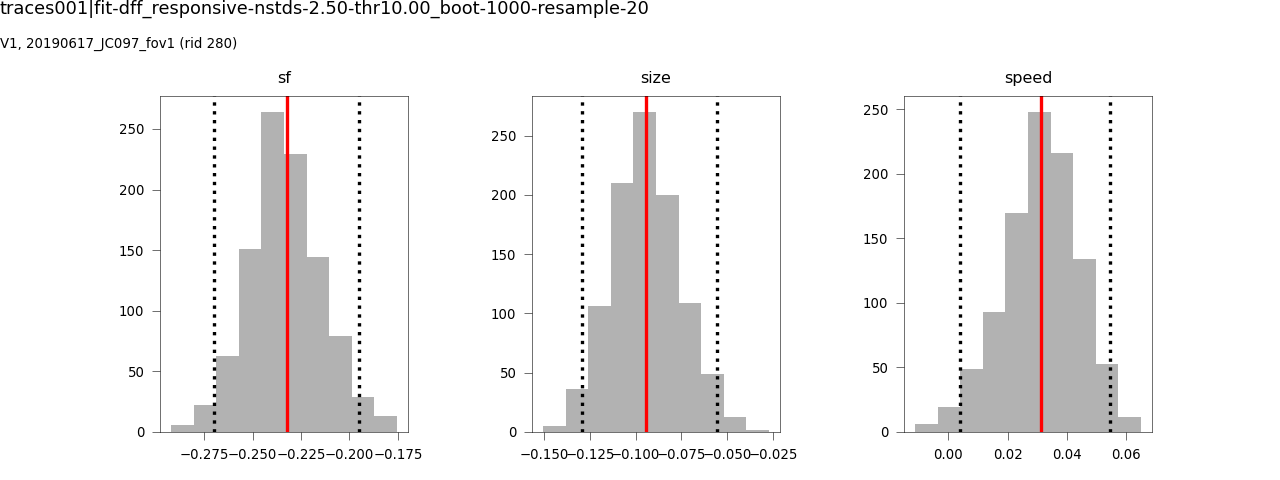

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics examples nonori_V1_20190617_JC097_fov1_rid280


In [179]:

pvals=[]
fig, axes = pl.subplots(1, 3, figsize=(8, 3))
for ax, param, ci_ in zip(axes.flat, ['sf', 'size', 'speed'], param_cis):
    iter_vs = iterd[param]
    ax.hist(iter_vs, color='k', alpha=0.3)
    reject_null = ~(ci_[0] < 0 < ci_[1])
    #ci_upper2 = np.percentile(ordered, alpha)
    true_v = float(true_[param])
    if reject_null:
        lcolor ='r'
    else:
        lcolor = 'k'
    ax.axvline(x=ci_[0], color='k', linestyle=':')
    ax.axvline(x=ci_[1], color='k', linestyle=':')
    ax.axvline(x=true_v, color=lcolor)
    ax.set_title(param)
    nonsig = ci_lower <= true_v<= ci_upper
    pvals.append(not nonsig)
fig.text(0, 0.9, '%s, %s (rid %i)' % (va, dk, rid))
pplot.label_figure(fig, data_id)
pl.subplots_adjust(wspace=0.5, hspace=0.8, top=0.8, bottom=0.1)

figname = 'nonori_%s_%s_rid%i' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, 'examples', '%s.svg' % figname))
print(curr_dst_dir, 'examples', figname)

In [181]:
true_

sf      -0.232310
size    -0.094366
speed    0.031167
dtype: float64

In [182]:
r_.loc[rid]

size    -0.094366
speed    0.031167
sf      -0.232310
Name: 280, dtype: float64

In [109]:
sf_lo, sz_lo, sp_lo = np.percentile(testd, (100-alpha)/2, axis=0)
sf_hi, sz_hi, sp_hi = np.percentile(testd, alpha+((100-alpha)/2), axis=0)
print(sf_lo, sz_lo, sp_lo)

-0.07162004857895753 -0.011886071667971395 -0.02623979624770266


In [101]:
sf_hi, sz_hi, sp_hi = np.percentile(testd, alpha+((100-alpha)/2), axis=0)

array([-0.05118127,  0.01001683, -0.00581061])

In [106]:
reject_null = (ci_lower < 0 < ci_upper)
reject_null

False

In [96]:
R = rdf.groupby(['cell']).apply(bootstrap_index_calculation, 
                            sdf=sdf, n_bootstrap_iters=100)

In [354]:
len(reliable_rois[reliable_rois==True].index.tolist())


60

In [355]:
len(rdf['cell'].unique())

65

In [332]:
rid = 0 #155 #280 #262 # Pref. sf=0.1
rd = rdf[rdf['cell']==rid].copy()

In [333]:
iters = bootstrap_nonori(rd)
is_r = is_reliable_or_no(rd, iters)
print(is_r)
# if is_r:
#     reliable_rois.append(rid)
        
        
# reliabe_=[]
# for (sz, sf, sp), g in rd.groupby(['size', 'sf', 'speed']):
#     iter_vs = iters[(iters['size']==sz) & (iters['sf']==sf) & (iters['speed']==sp)]
#     ordered = sorted(iter_vs['response'])
#     ci_lower = np.percentile(ordered, (100-alpha)/2)
#     ci_upper = np.percentile(ordered, alpha+((100-alpha)/2))
#     true_v =float(g['response'].mean())
#     r_val = ci_lower>0 and (ci_lower<true_v<ci_upper)
#     reliable_.append(r_val)
# if any(reliable_):
#     reliable_rois.append(rid)

True


In [283]:
figname = 'nonori_%s_%s_rid%i' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, 'examples', '%s.svg' % figname))
print(curr_dst_dir, 'examples', figname)

'/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/aggregate_metrics'

In [325]:
p_ixs={}
for p in paramnames:
    lo, hi = rd[p].unique().min(), rd[p].unique().max()
    v1 = rd[rd[p]==lo]['response'].mean() 
    v2 = rd[rd[p]==hi]['response'].mean() 
    ix = (v1-v2)/(v1+v2) # +1 smaller preferred, -1 bigger val preferred
    p_ixs.update({p: ix})
pd.DataFrame(p_ixs, index=[rid])

size     speed        sf
280  0.374773 -0.123779  0.922612

In [317]:
(v1-v2)/(v1+v2)

0.9226119166018091

In [318]:
rid

280